In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# **Lab 7**
I am choosing to use the sample of pT from 250 to 500. To normalize the datasets, each event is given weight equal to the expected yield divided by the number of events in the sample. This way the sum of the histograms equals the expected yeild for the qcd and higgs samples. 

In [85]:
open_qcd = open('qcd_100000_pt_250_500.pkl', 'rb')
qcd_data = pickle.load(open_qcd)
open_qcd.close()

open_higgs = open('higgs_100000_pt_250_500.pkl', 'rb')
higgs_data = pickle.load(open_higgs)
open_higgs.close()

### **1**  
*Make a stacked histogram plot for the feature variable mass*

Text(0, 0.5, 'Events')

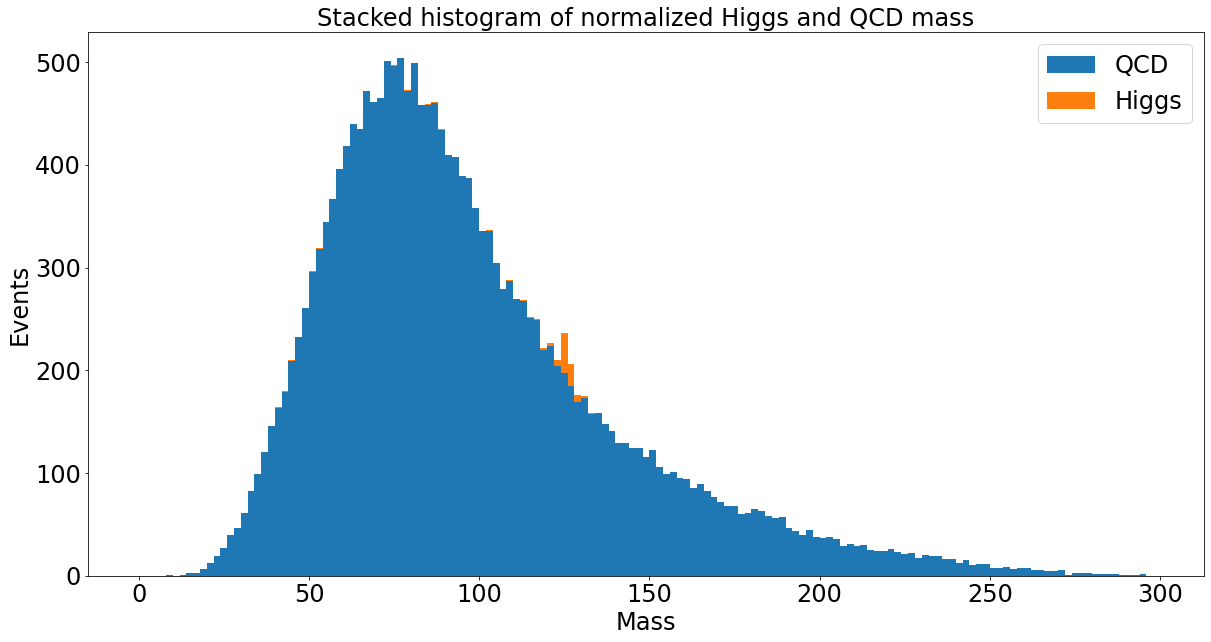

In [88]:
fig, ax = plt.subplots(1,1, figsize = (20, 10))
plt.tick_params(labelsize = 24)

# Create weights arrays so that the histograms are normalized to give expected yeilds
higgs_weights = np.repeat(100/len(higgs_data['mass']), len(higgs_data['mass'])) # Nhiggs = 100
qcd_weights = np.repeat((20000/len(qcd_data['mass'])), len(qcd_data['mass'])) # Nqcd = 20000


bins = np.arange(0, 300, 2)

heights, temp1, temp2 = ax.hist([qcd_data['mass'], higgs_data['mass']],
                                bins = bins, 
                                weights = [qcd_weights, higgs_weights], 
                                stacked = True,
                                label = ["QCD", "Higgs"])
ax.legend(fontsize = 24)
ax.set_title("Stacked histogram of normalized Higgs and QCD mass", fontsize = 24)
ax.set_xlabel("Mass", fontsize = 24)
ax.set_ylabel("Events", fontsize = 24)


The above stacked bar histogram shows the normalized qcd sample plotted on top of the normalized higgs dataset for the mass feature. From the histogram, there is a clear peak in mass around 125 GeV. 

* *Evaluate the expected significance without any event selection*
  * *Use Poisson statistics for significance calculation*  

Using only poisson statistics, the expected number of background events is $N_{QDC} = 20000$ and the expected number of Higgs is $N_{Higgs} = 100$. The significance is that of 20100 events detected for a poisson background of 20000.


In [89]:
prob = stats.poisson.sf(20100, mu = 20000)
sig = stats.norm.isf(prob, loc = 0, scale = 1)
print(f"The expected significance is {sig:0.02} sigma")

The expected significance is 0.71 sigma


   * *Compare the exact significance to the approximation $N_{Higgs} / \sqrt{N_{QCD}} $. If they are the same, explain*  

In [90]:
sigApprox = 100 / np.sqrt(20000)
print(f"The approximate expected significance is {sigApprox:0.02} sigma")

The approximate expected significance is 0.71 sigma


These two results are indeed the exact same. The reason for this is that for many poisson distributions convolved together, the result begins to look like a gaussian distribution of mean mu and standard deviation equal to square root of mu for the corresponding poisson distribution. Significance is the measure of how far from the mean some signal is in units of sigma. Therefore, since we can approximate the standard deviation of the poisson distributio as the square root of mu, the significance of the signal is the quotient of the expected signal divided by the sigma. 

### **2**  
*Identify cuts to optimize the expected significance:*
* *Try different cuts systematically*
* *Evaluate the expected significance for each set of mass cuts*
* *Identify the set of mass cuts which gives the highest significance*  


To decide on the optimal cut, I need to find the upper and lower bounds of the cut that gives the highest significance. These will be the individual cuts, for all the data greater then some lower bound and all the data less than some upper bound, that maximize the significance. The combination of these two cuts will give the greatest significance cut for mass. 

In [9]:
def sigPlot(feature, higgs_sample = higgs_data, qcd_sample = qcd_data):
    _, qcd_bins, = np.histogram(qcd_sample[feature], bins = 100)

    sig_above = []
    sig_below = []

    for i in range(len(qcd_bins)):
        higgs_cut_above = higgs_sample[feature][higgs_sample[feature] > qcd_bins[i]]
        qcd_cut_above = qcd_sample[feature][qcd_sample[feature] > qcd_bins[i]]

        higgs_cut_below = higgs_sample[feature][higgs_sample[feature] < qcd_bins[i]]
        qcd_cut_below = qcd_sample[feature][qcd_sample[feature] < qcd_bins[i]]

        qcd_weights_above = np.repeat(20000/100000, len(qcd_cut_above)) 
        higgs_weights_above = np.repeat( 100/100000, len(higgs_cut_above))

        qcd_weights_below = np.repeat(20000/100000, len(qcd_cut_below))
        higgs_weights_below = np.repeat( 100/100000, len(higgs_cut_below))

        qcd_heights_above, _, = np.histogram(qcd_cut_above, bins = qcd_bins[i:], weights = qcd_weights_above)
        higgs_heights_above, _, = np.histogram(higgs_cut_above, bins = qcd_bins[i:], weights = higgs_weights_above)

        qcd_heights_below, _, = np.histogram(qcd_cut_below, bins = qcd_bins[:i], weights = qcd_weights_below)
        higgs_heights_below, _, = np.histogram(higgs_cut_below, bins = qcd_bins[:i], weights = higgs_weights_below)

        qcd_yield_above = sum(qcd_heights_above)
        higgs_yield_above = sum(higgs_heights_above)

        qcd_yield_below = sum(qcd_heights_below)
        higgs_yield_below = sum(higgs_heights_below)

        prob = stats.poisson.sf(qcd_yield_above + higgs_yield_above, mu = qcd_yield_above)
        sig_above.append(stats.norm.isf(prob, loc = 0, scale = 1))

        prob = stats.poisson.sf(qcd_yield_below + higgs_yield_below, mu = qcd_yield_below)
        sig_below.append(stats.norm.isf(prob, loc = 0, scale = 1))

    fig, ax = plt.subplots(1,1, figsize = (20, 10))
    plt.tick_params(labelsize = 24)

    ax.plot(qcd_bins, sig_above, label = "Upper Cuts", linewidth = 3)
    ax.plot(qcd_bins, sig_below, label = "Lower Cuts", linewidth = 3)
    ax.legend(fontsize = 24)
    ax.set_title(f"Significance for cuts of {feature} above and below x", fontsize = 24)
    ax.set_xlabel("Cut", fontsize = 24)
    ax.set_ylabel("Significane", fontsize = 24)

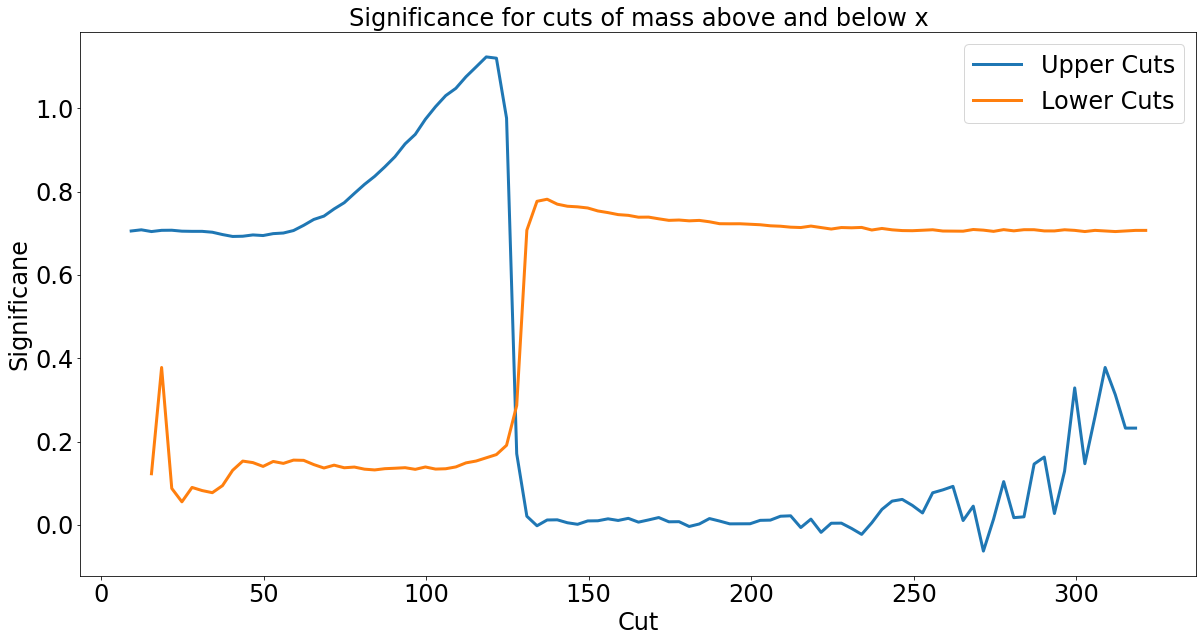

In [10]:
sigPlot('mass')

The plot above shows the expected significance for cuts made at the values along the x axis. Lower cuts keep data below the corresponding cut value and upper cuts keep data above the corresponding mass value. A cut that is likely to give a high significance is from the peak of the upper cut curve to the the mass value that corresponds to the peak of the lower cut curve. Below I define a function that creates a plot using the upper and lower bounds of a cut on some feature.

In [95]:
def makeStats(lower_bound, upper_bound, feature, higgs_sample = higgs_data, qcd_sample = qcd_data):
    """
    Makes a histogram and outputs the expected significance
    """
    higgs_upper = higgs_sample[feature][higgs_sample[feature] > lower_bound]
    higgs_cut2 = higgs_upper[higgs_upper < upper_bound]
                                     
    qcd_upper = qcd_sample[feature][qcd_sample[feature] > lower_bound]
    qcd_cut2 = qcd_upper[qcd_upper < upper_bound]

    
    
    qcd_weights = np.repeat(20000/100000, len(qcd_cut2))
    higgs_weights = np.repeat( 100/100000, len(higgs_cut2))

    fig, ax = plt.subplots(1,1, figsize = (20, 10))
    plt.tick_params(labelsize = 24)
    
    heights, temp1, temp2 = ax.hist([higgs_cut2, qcd_cut2],
                                    bins = 100, 
                                    weights = [higgs_weights, qcd_weights], 
                                    stacked = True,
                                    label = ["Higgs", "QCD"])
    ax.legend(fontsize = 24)
    ax.set_title(f"Stacked histogram of normalized Higgs and QCD {feature}", fontsize = 24)
    ax.set_xlabel(f"{feature}", fontsize = 24)
    ax.set_ylabel("Events", fontsize = 24)

    qcd_yield = sum(heights[1]- heights[0])
    higgs_yield = sum(heights[0])
    print(f'higgs yield = {higgs_yield:0.0f}')
    print(f'qcd yield = {qcd_yield:0.0f}')

    prob = stats.poisson.sf(qcd_yield + higgs_yield, mu = qcd_yield)
    sig = stats.norm.isf(prob, loc = 0, scale = 1)
    
    print(f"The expected significance is {sig:0.02}")

higgs yield = 54
qcd yield = 287
The expected significance is 3.1


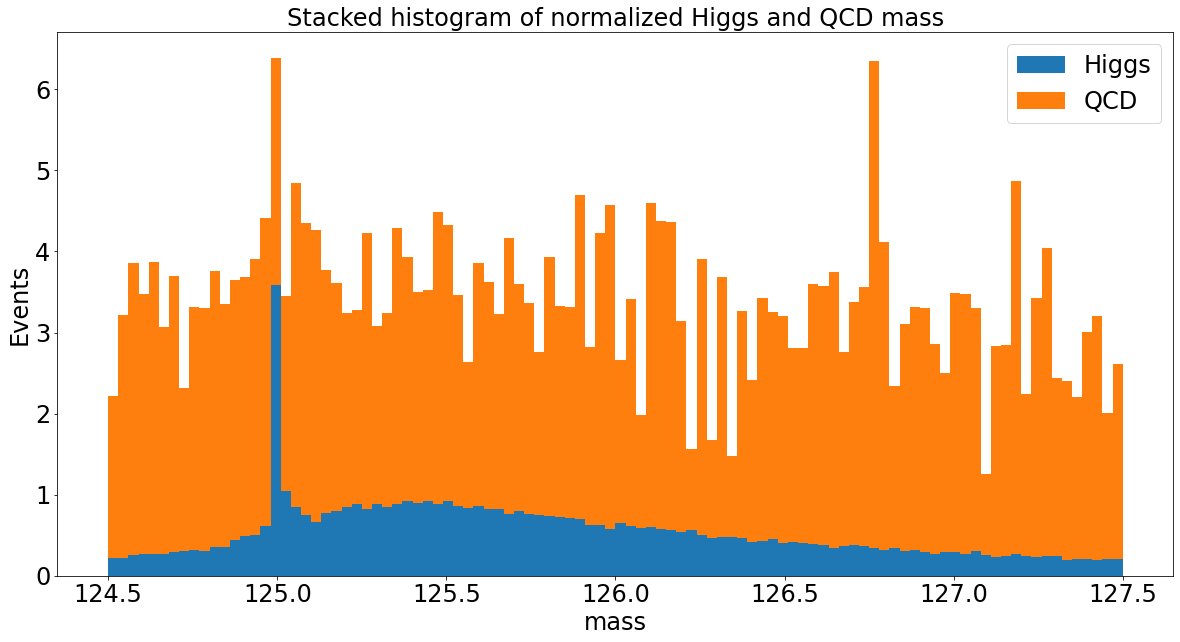

In [96]:
makeStats(124.5, 127.5, 'mass')

The mass cut that gives the highest significance is somewhere between 120 and 130. The above plot shows the mass cut that gives the highest. Tightening the bounds of the cut increases the significance more however, tightening the bounds also decreases the number of higgs saved in the sample. This is not desirable because the uncertainty increase as the number of higgs decreases. In order to maintain data credibility, for the rest of this analysis I will try to retain ~2/3 of the higgs events.

# **3**  
*Make two sets of stacked histograms for the rest of the variables: One set with no event selection, one with optimal mass cuts*

In [97]:
def hists(feature, higgs_sample = higgs_data, qcd_sample = qcd_data,):
    fig, ax = plt.subplots(1,1, figsize = (20, 10))
    plt.tick_params(labelsize = 24)

    # Create weights arrays so that the histograms are normalized to give expected yeilds
    higgs_weights = np.repeat(100/100000, len(higgs_sample[feature])) # Nhiggs = 100
    qcd_weights = np.repeat(20000/100000, len(qcd_sample[feature])) # Nqcd = 20000
    
    heights, temp1, temp2 = ax.hist([higgs_sample[feature], qcd_sample[feature]],
                                    bins = 200, 
                                    weights = [higgs_weights, qcd_weights], 
                                    stacked = True,
                                    label = ["Higgs", "QCD"])
    ax.legend(fontsize = 24)
    ax.set_title(f"Stacked histogram of normalized Higgs and QCD: {feature}", fontsize = 24)
    ax.set_xlabel(f"{feature}", fontsize = 24)
    ax.set_ylabel("Events", fontsize = 24)

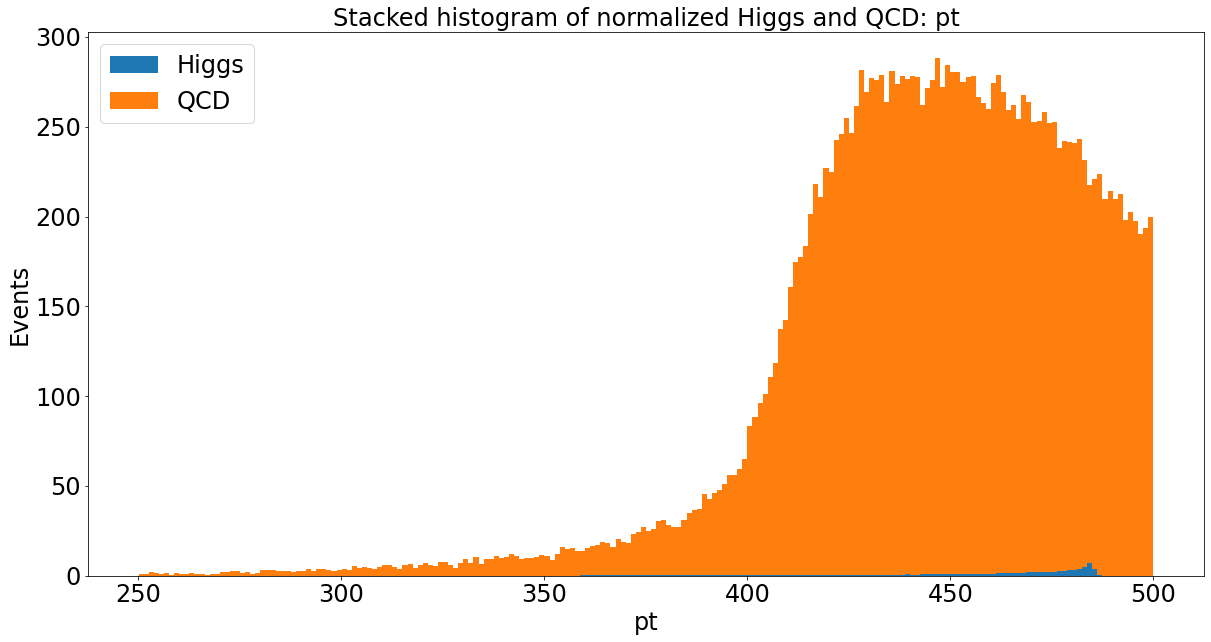

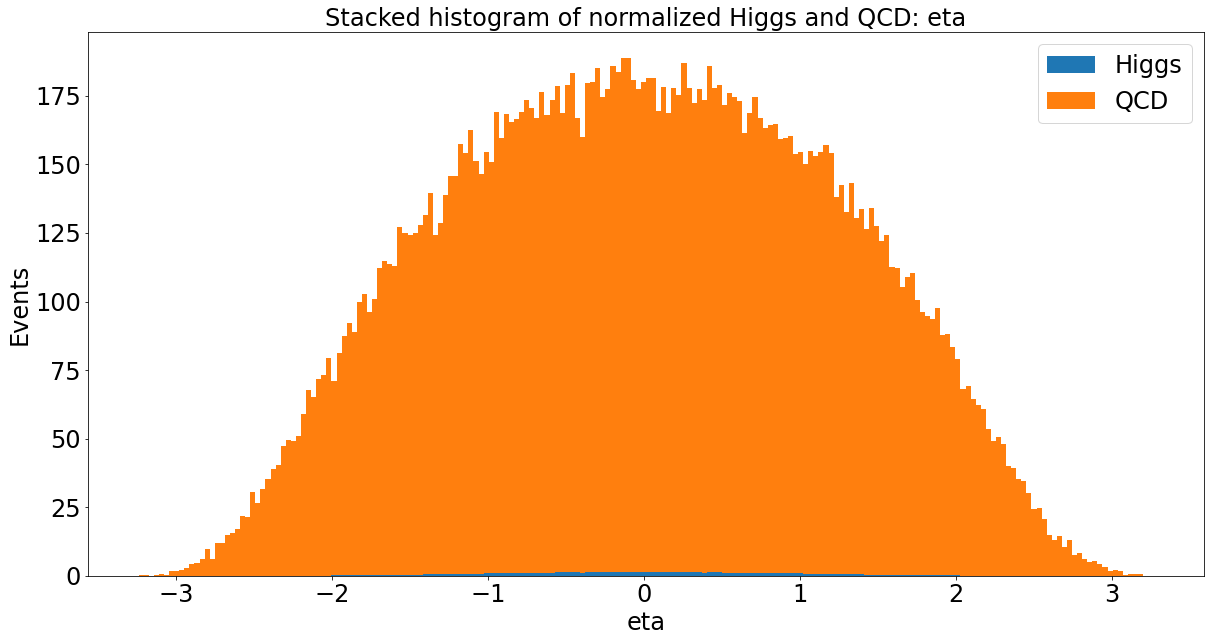

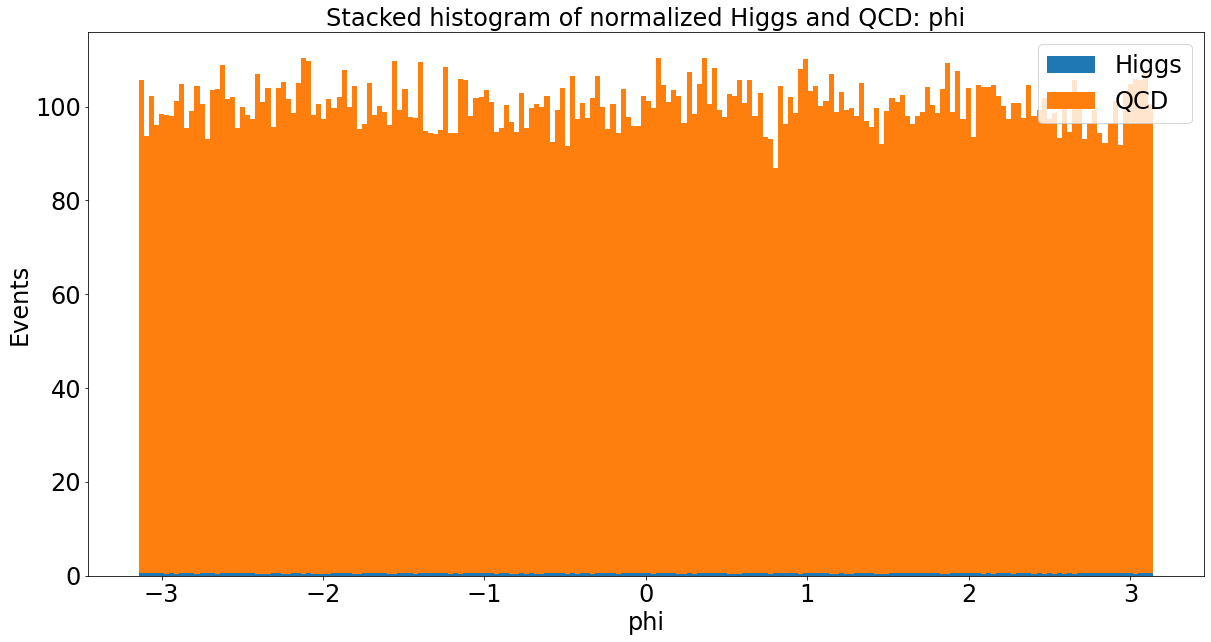

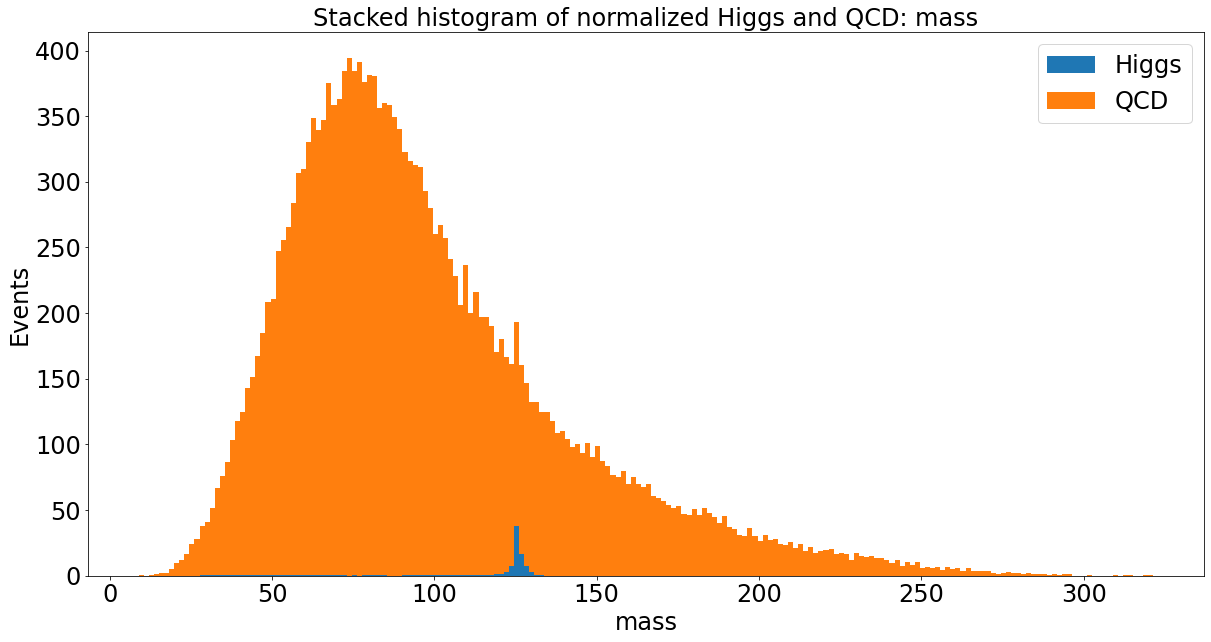

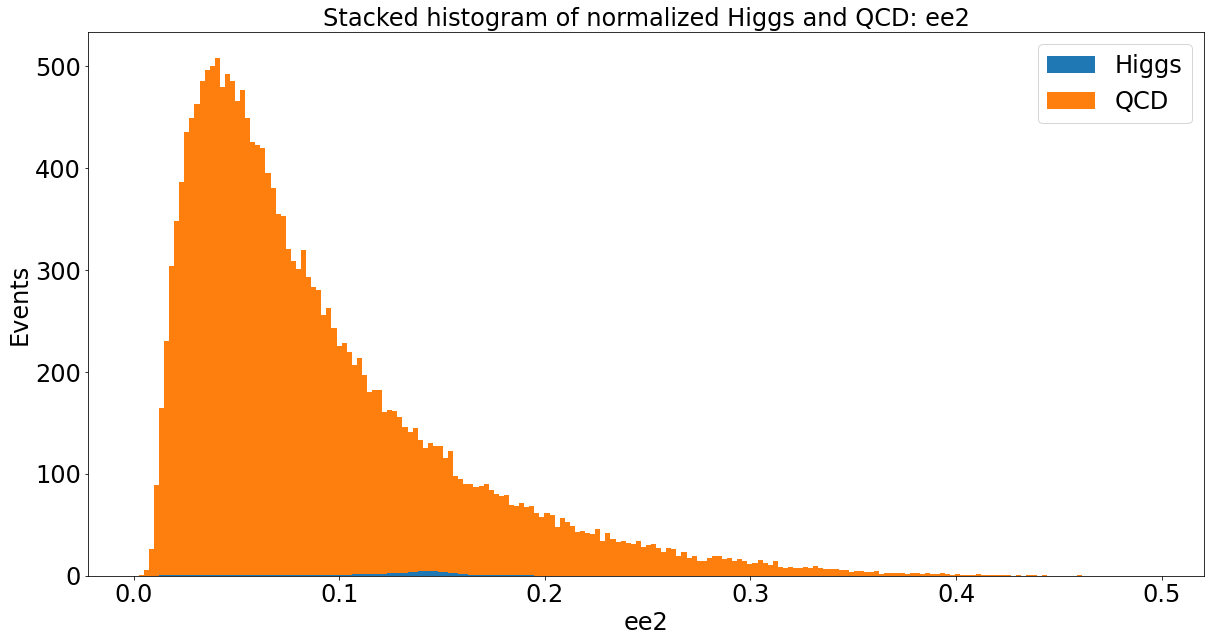

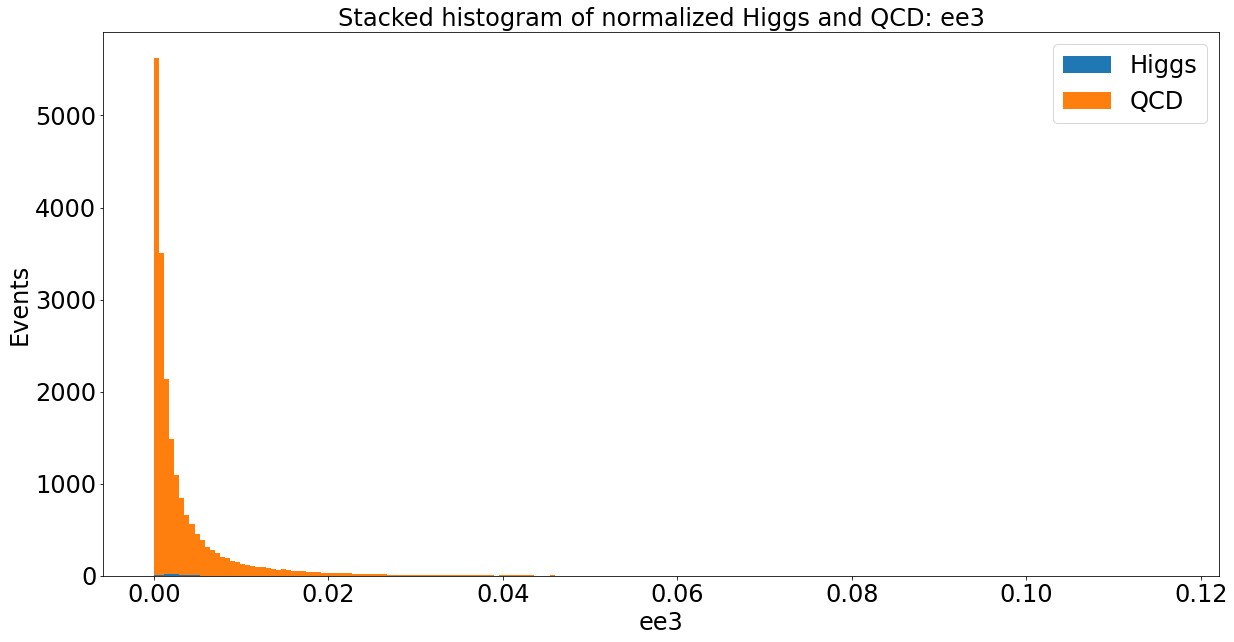

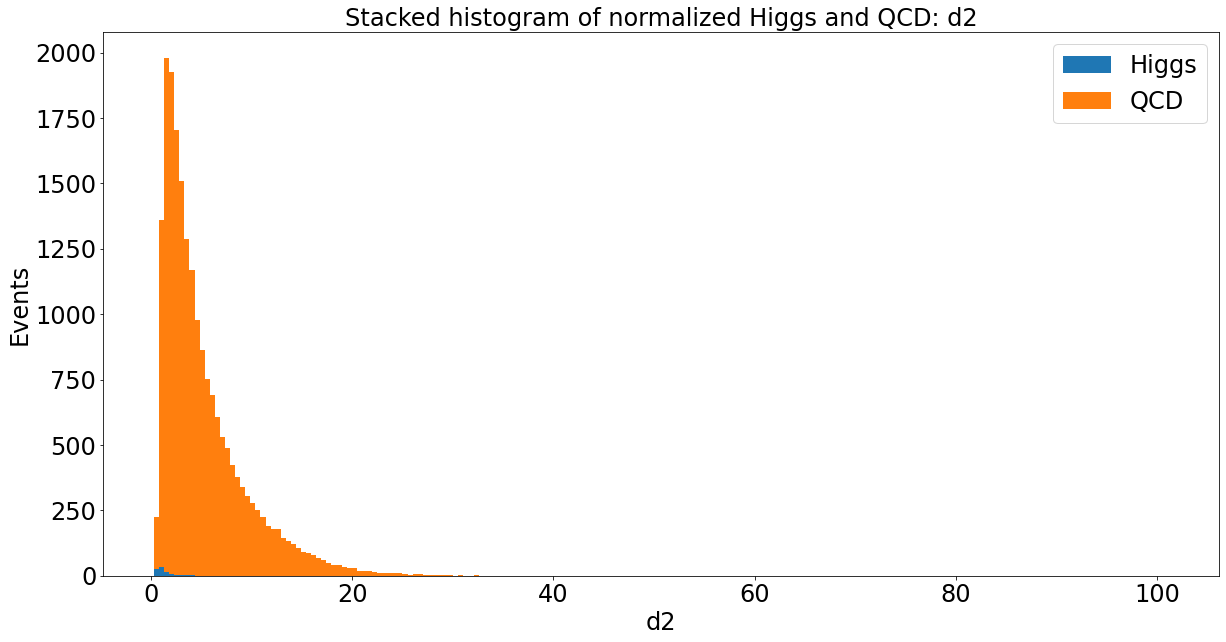

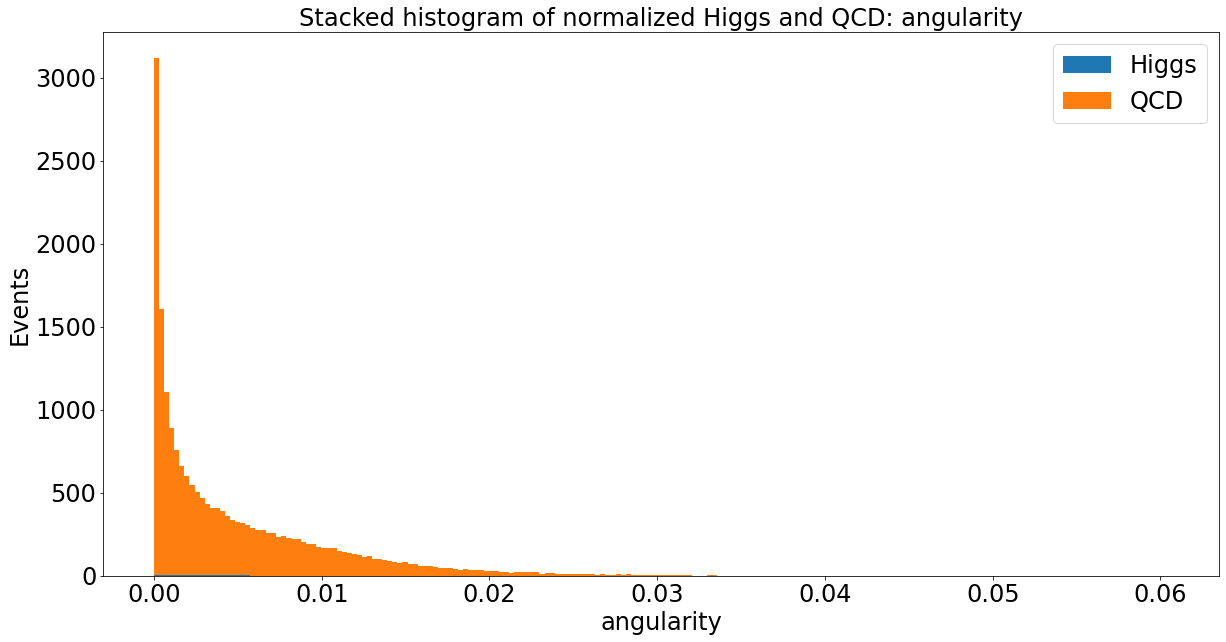

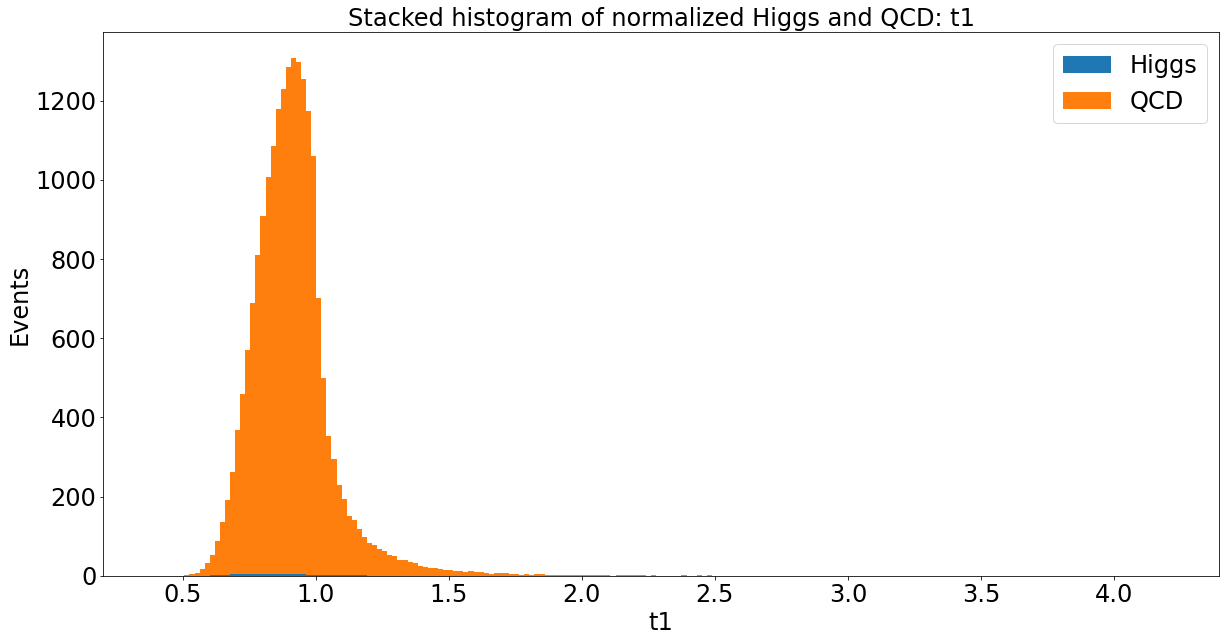

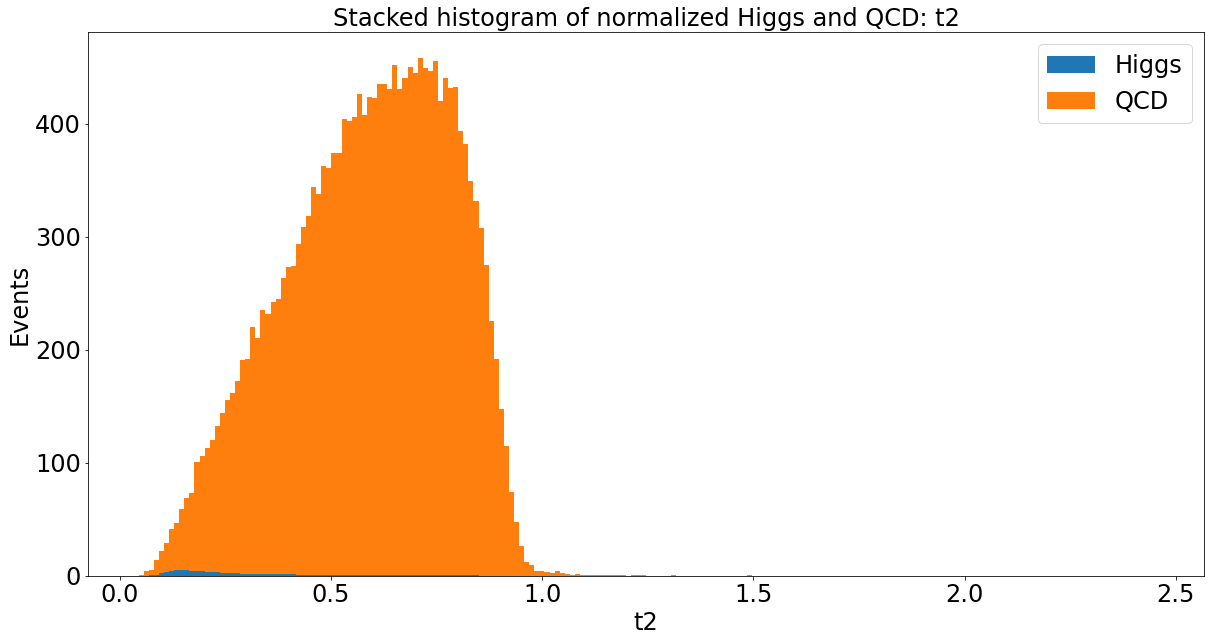

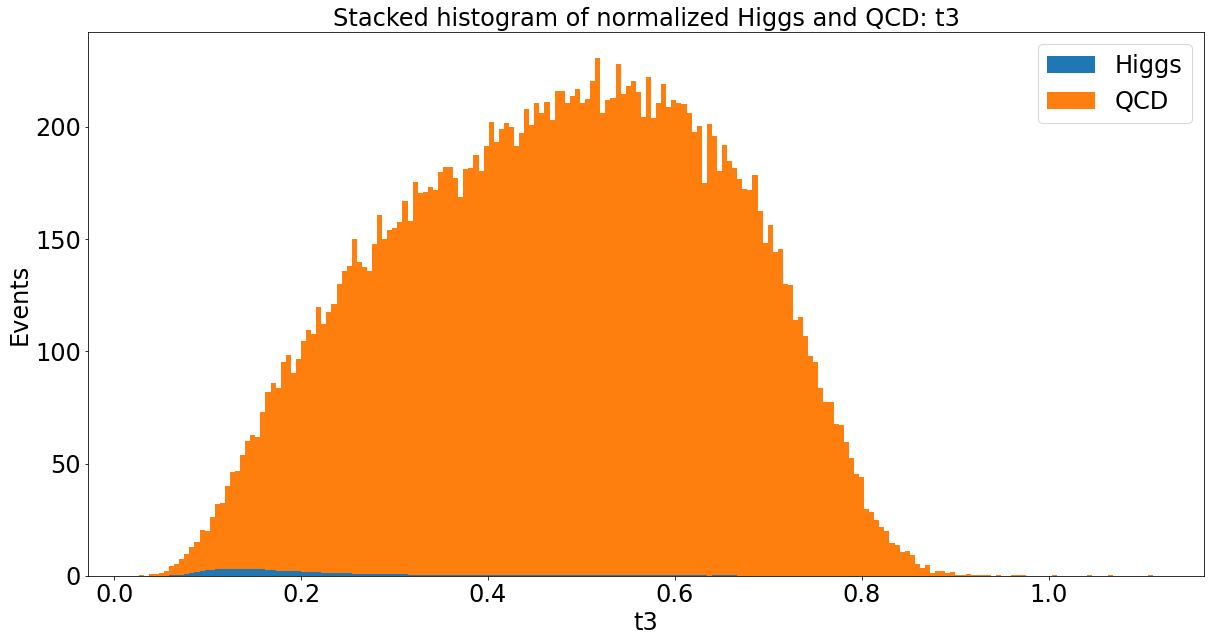

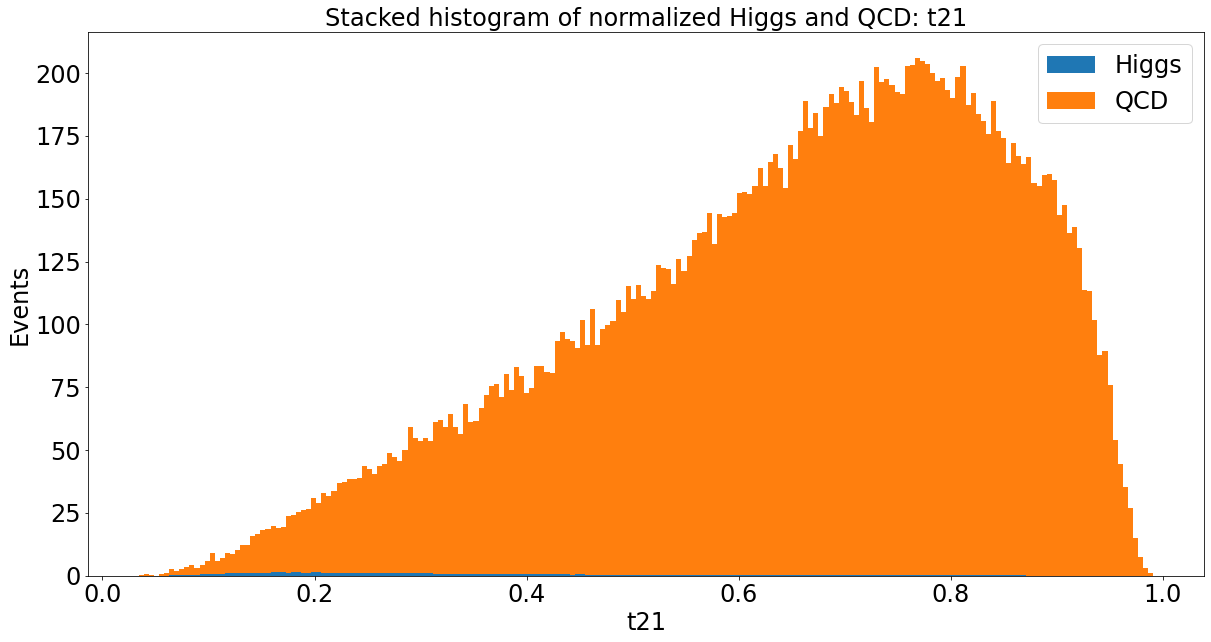

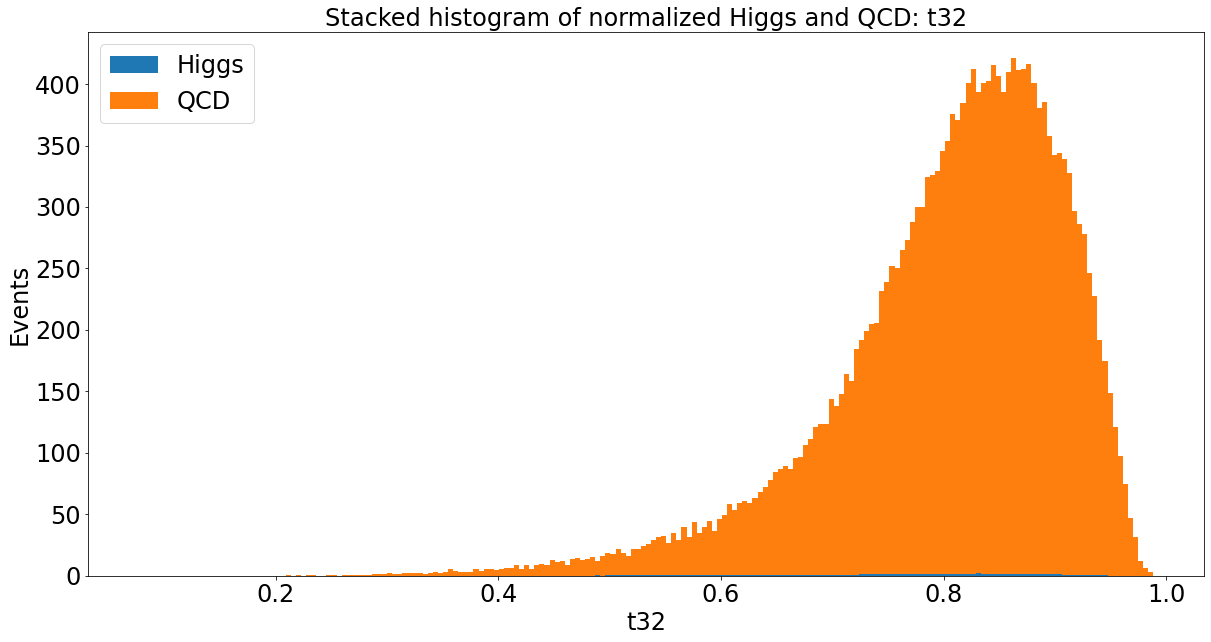

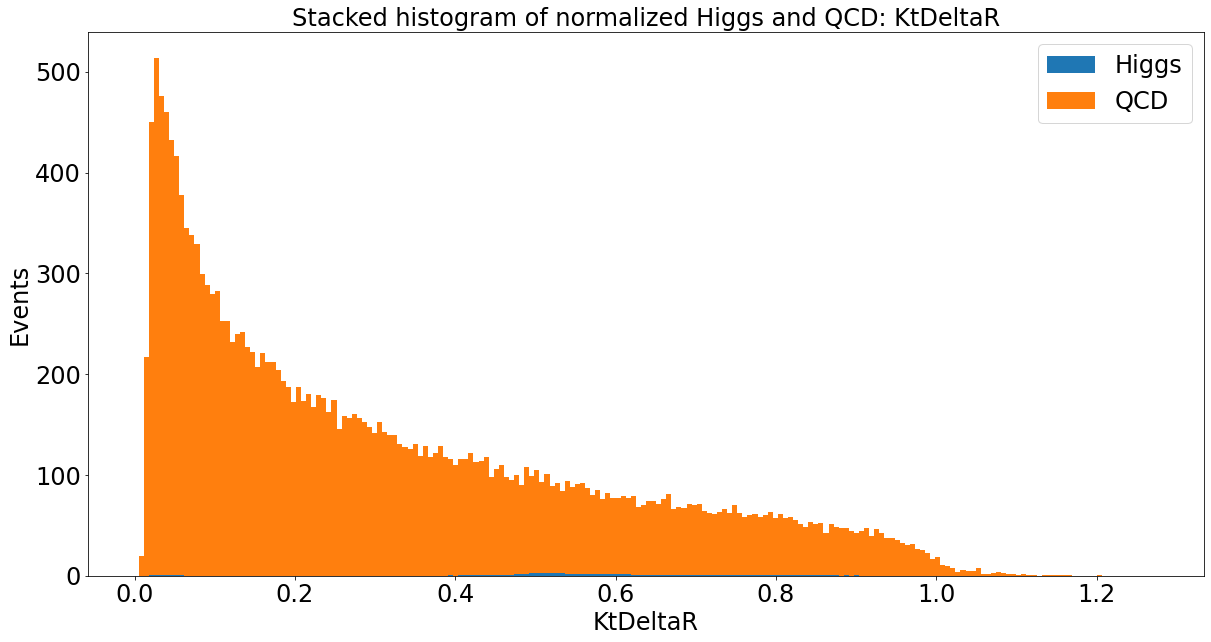

In [98]:
cols = higgs_data.columns
for i in cols:
    hists(i)

The plots above are the stacked histograms for each of the features of the Higgs and QCD samples. The features that look like they may also be good discriminators are pt, ee2, ee3, d2 and t2. To evaluate whether these have the same amount of discrimination power as the mass feature, plots of the significance for different cuts are made for each of pt, ee2, ee3, d2, t2 to better identify the upper and lower bounds for the best cut. 

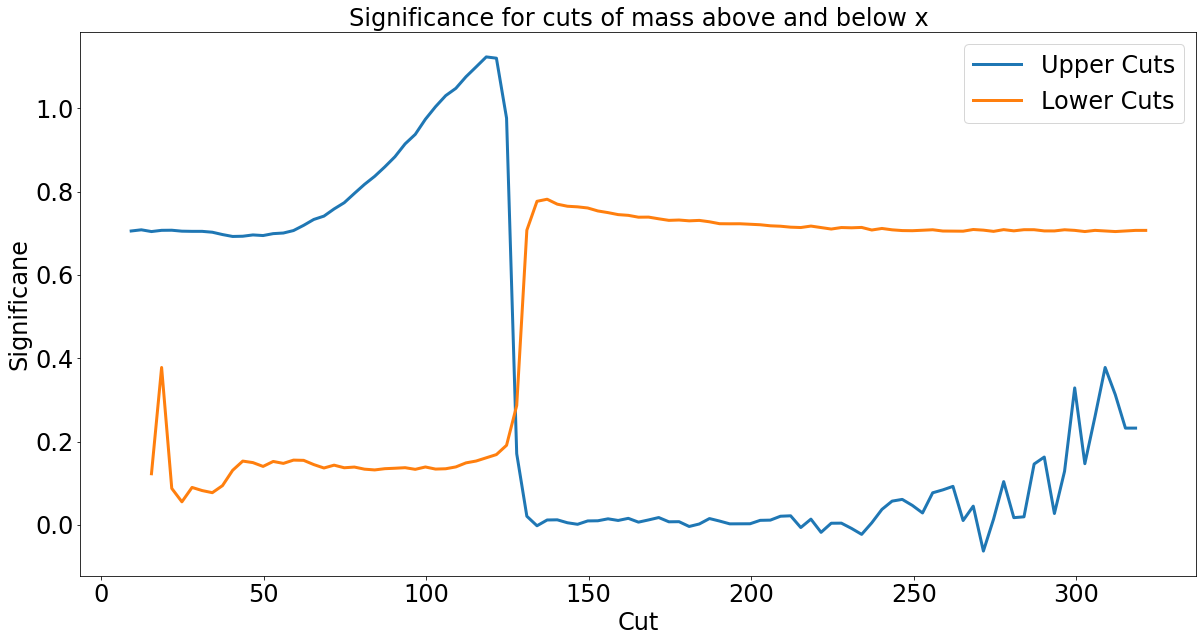

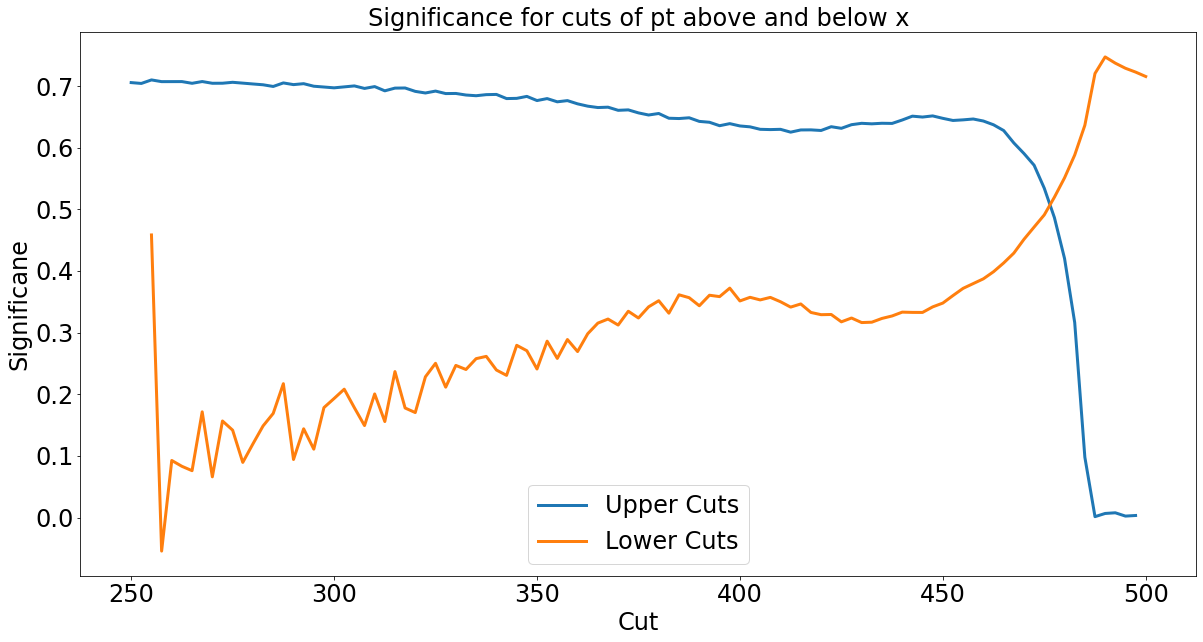

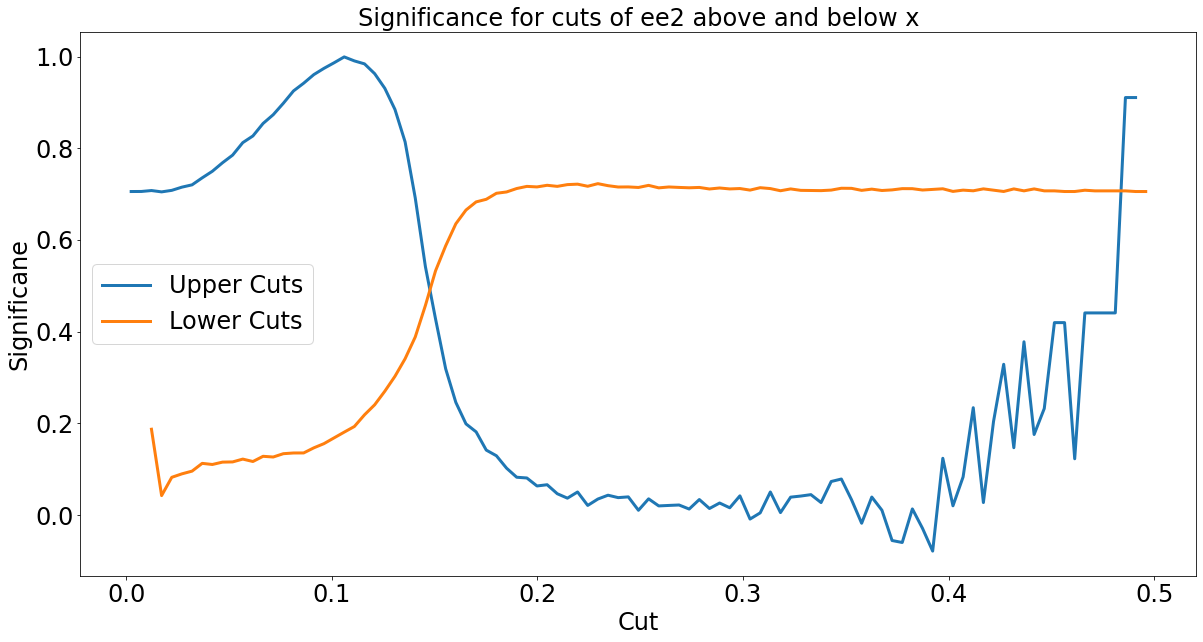

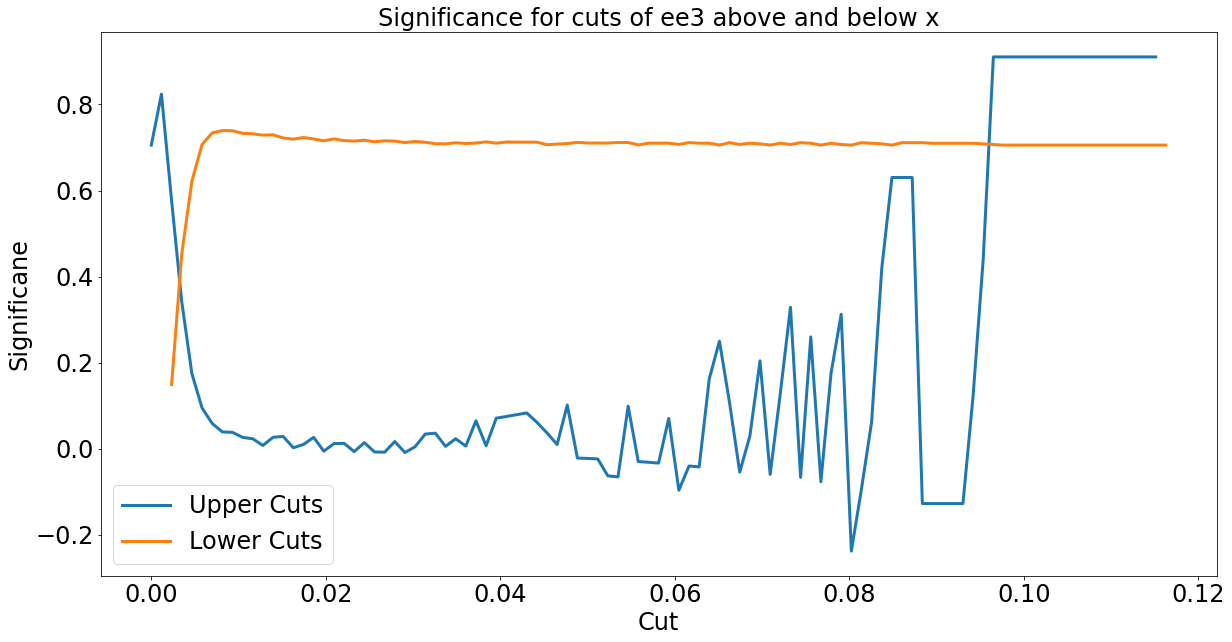

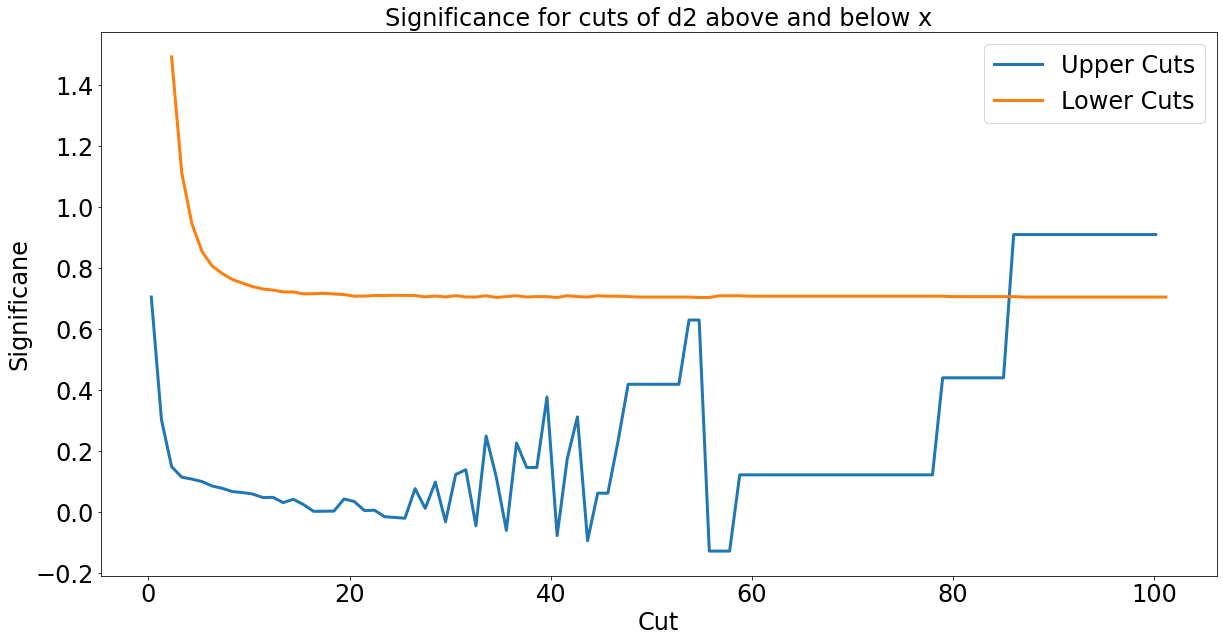

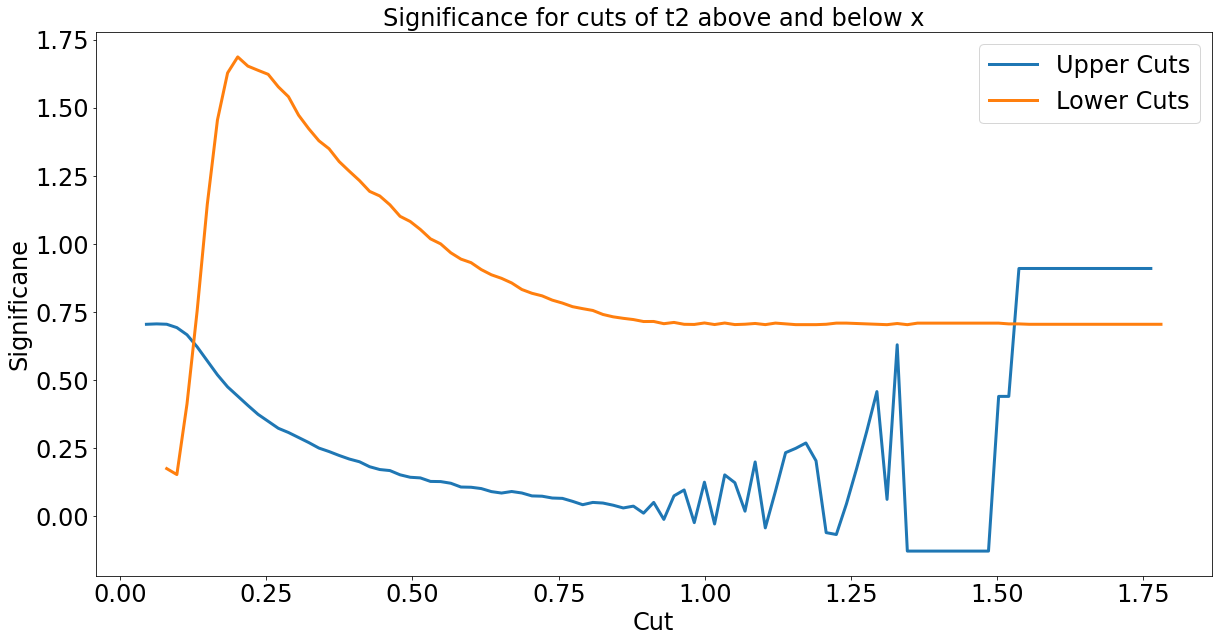

In [15]:
candidates = ['mass', 'pt', 'ee2', 'ee3', 'd2', 't2']
for i in candidates: 
    sigPlot(i)

From the above plots the best cut for a given feature corresponds to the maximum of the significance for the upper and lower bounds. For instance for ee2, the 'upper cut' has a maximum around 0.1 which would correspond to the lower bound. The 'lower cut' has a maximim around 0.17 which corresponds to the upper bound. This cut of ee2 is plotted below. The same procedure is followed for t2 and d2 which appear to be the most discriminative. 

higgs yield = 72
qcd yield = 4132
The expected significance is 1.1
higgs yield = 51
qcd yield = 1043
The expected significance is 1.6
higgs yield = 42
qcd yield = 628
The expected significance is 1.7


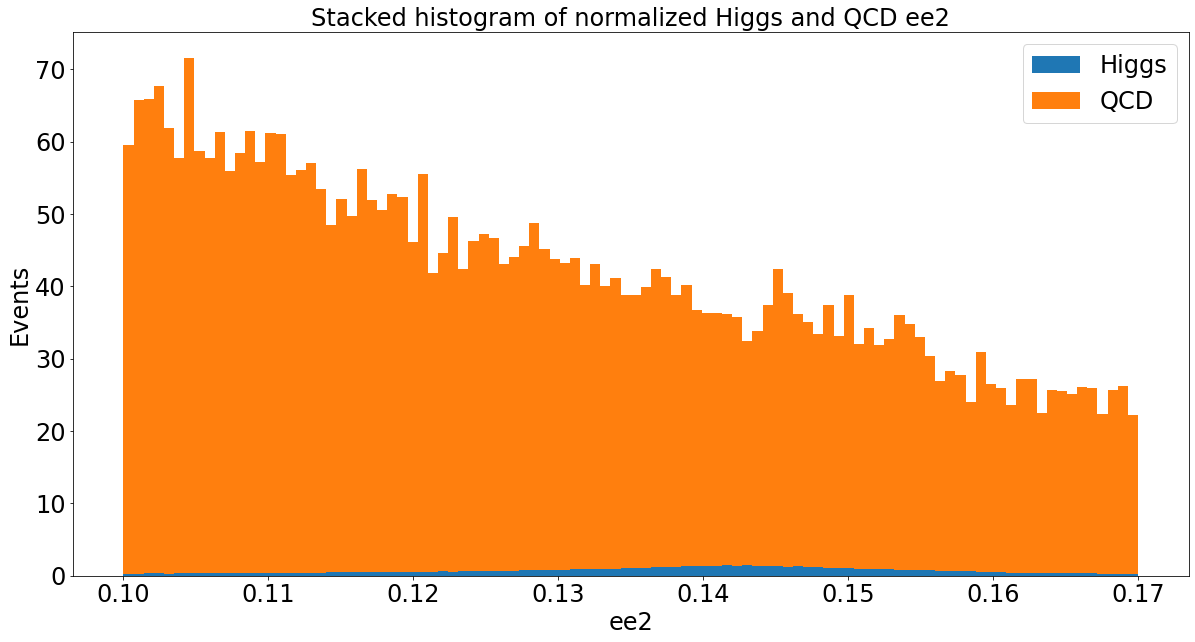

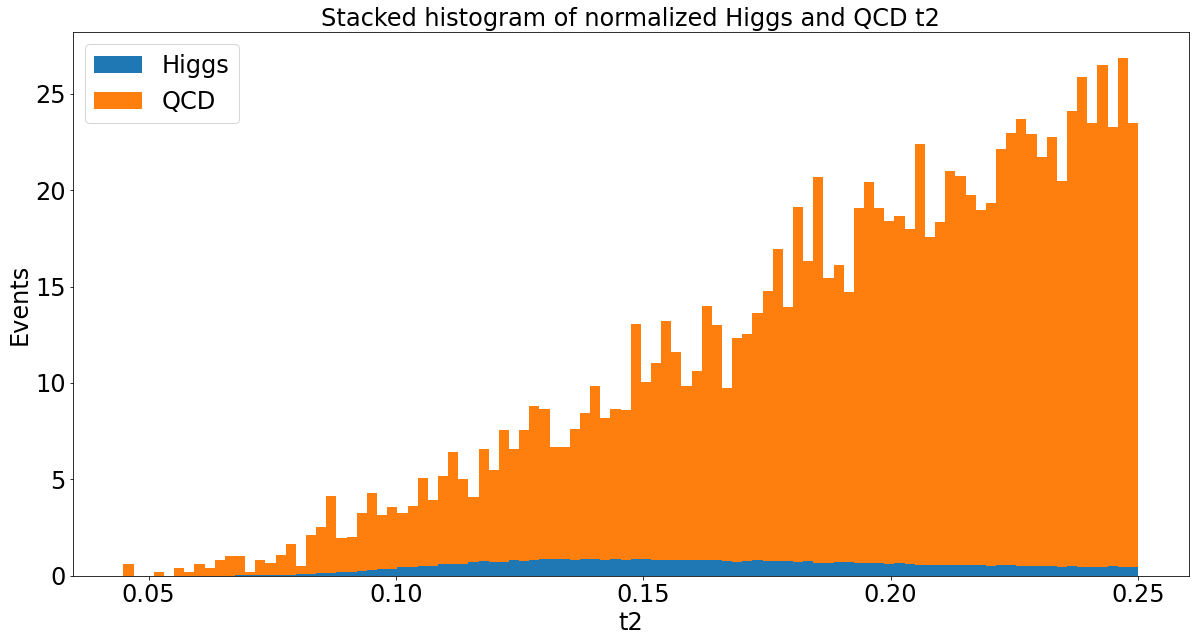

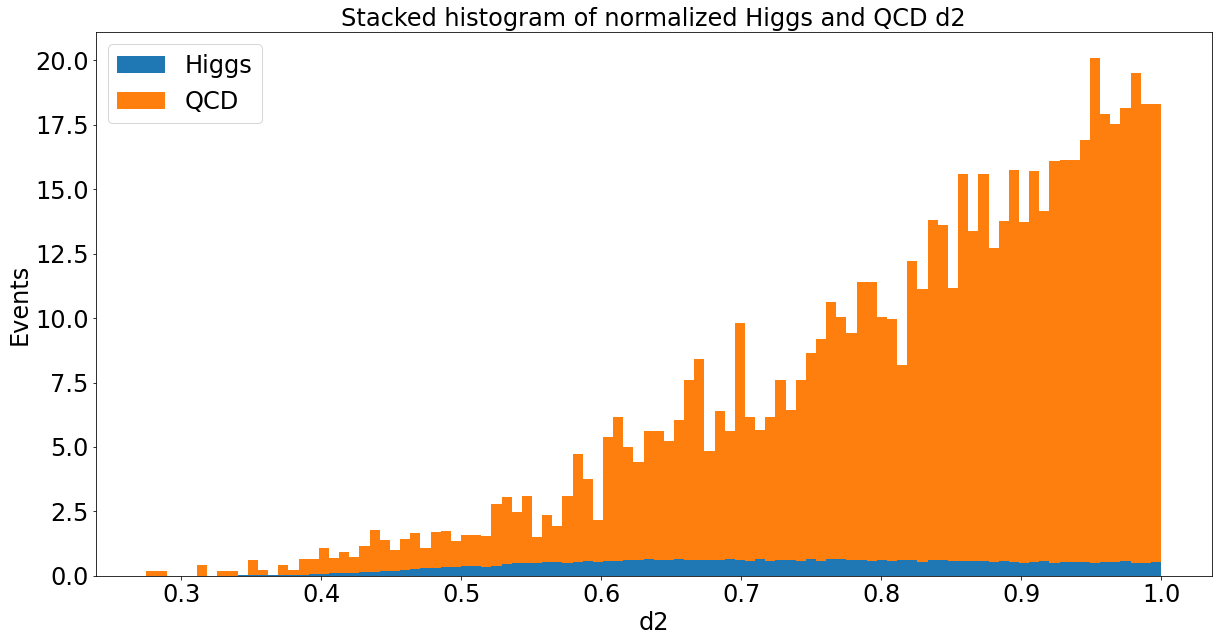

In [16]:
makeStats(0.1, 0.17, 'ee2')
makeStats(0, 0.25, 't2')
makeStats(0, 1, 'd2')

The best cuts for the candidate variables are given above. The features d2 and t2 are the only ones that offer distinctly better discrimination over the other features, however none of them offer as much discrimination as mass. Furthermore of the three candidate features, only d2 preservers the desired 2/3 of the higgs events.

*Stacked histograms of all of the features with optimal mass cuts. Identify features to improve the expected significnace*

For this part, a mass cut of 

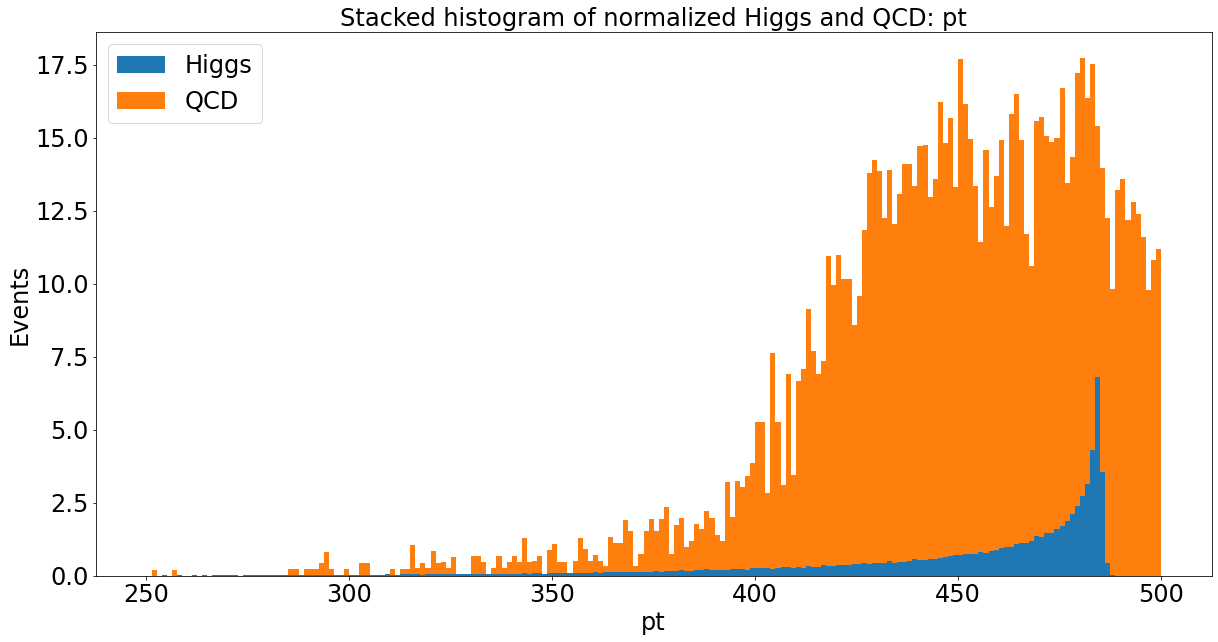

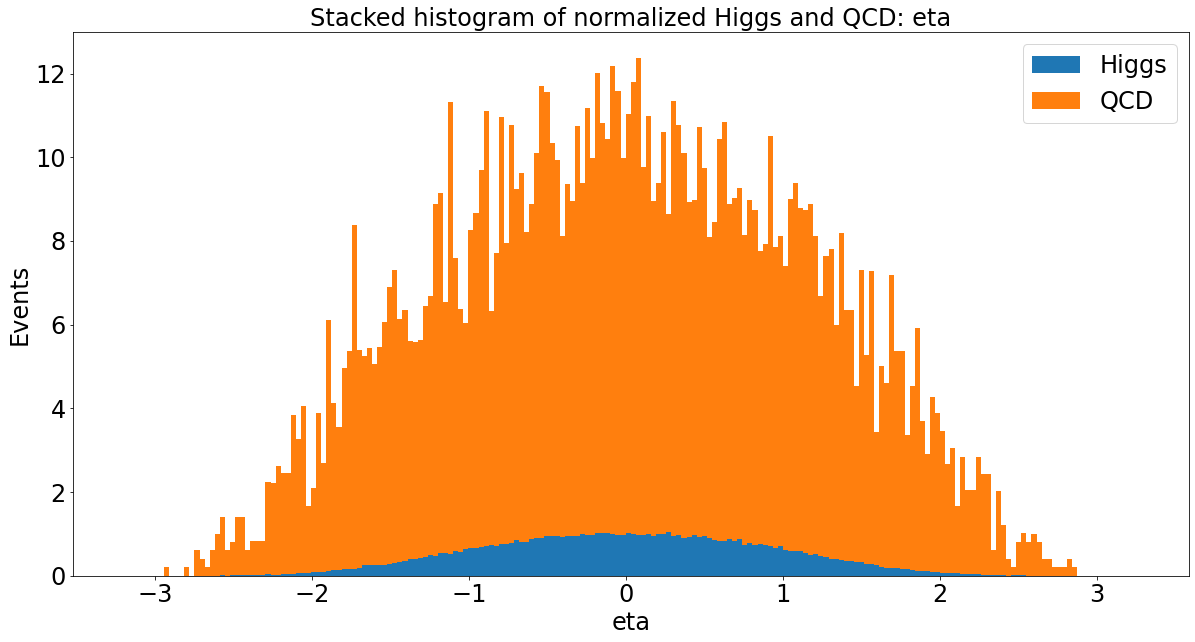

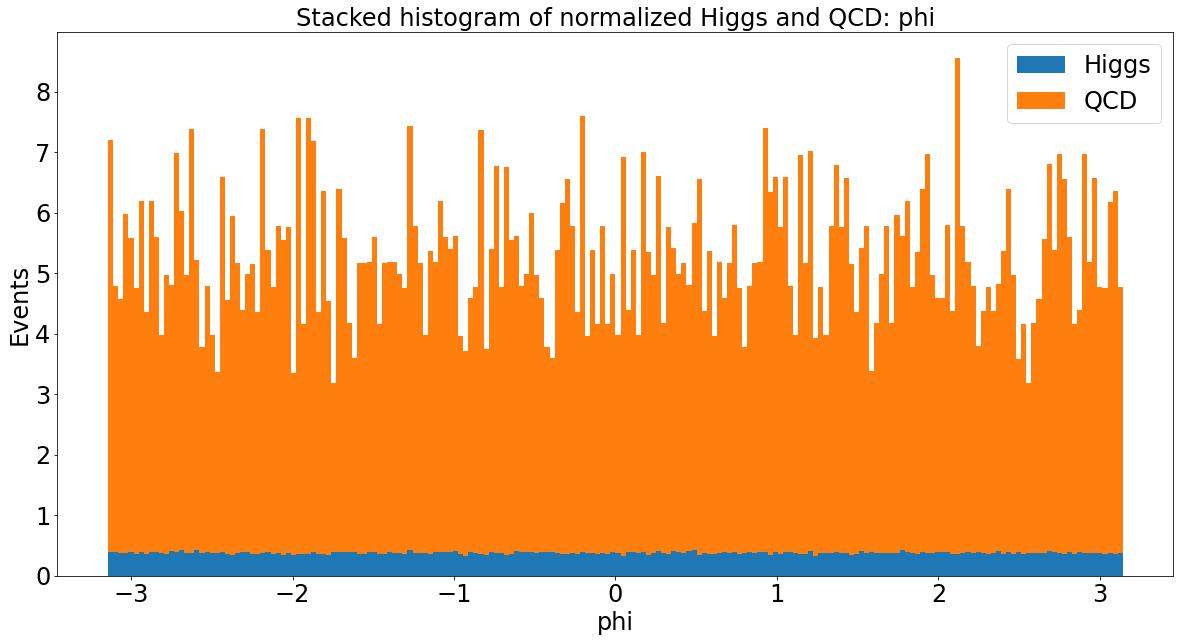

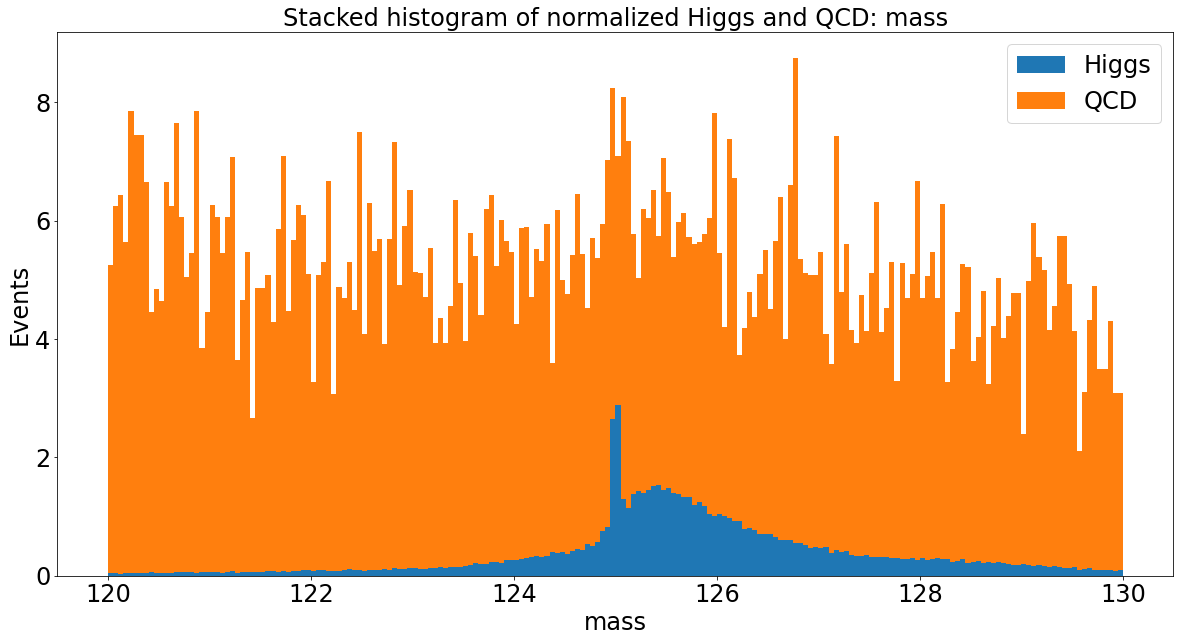

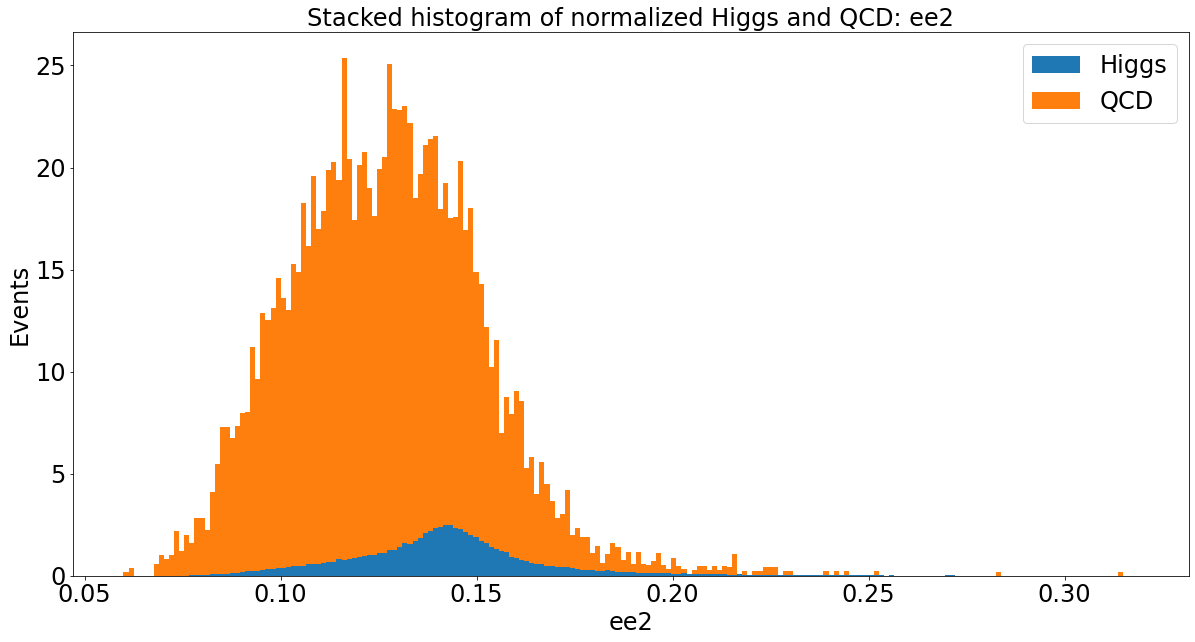

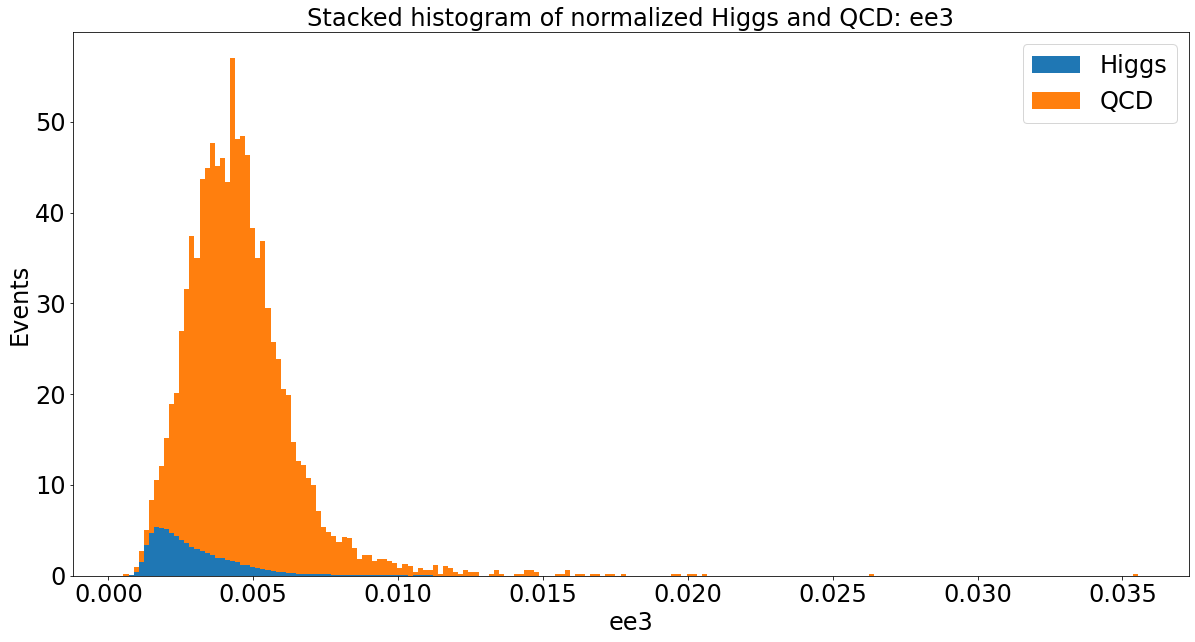

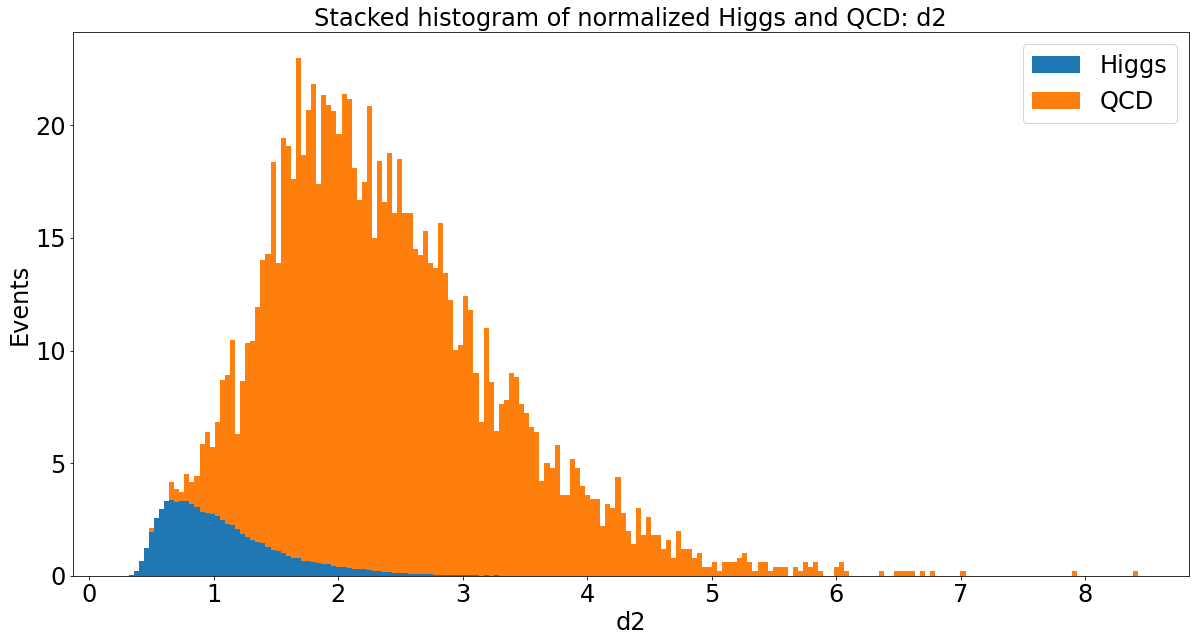

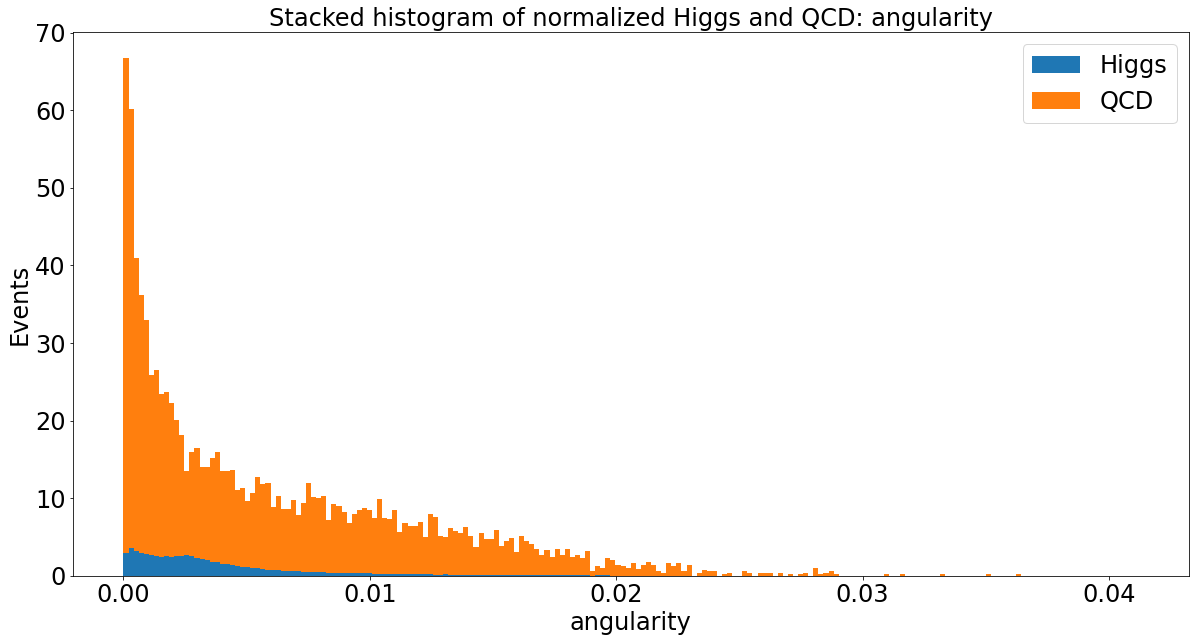

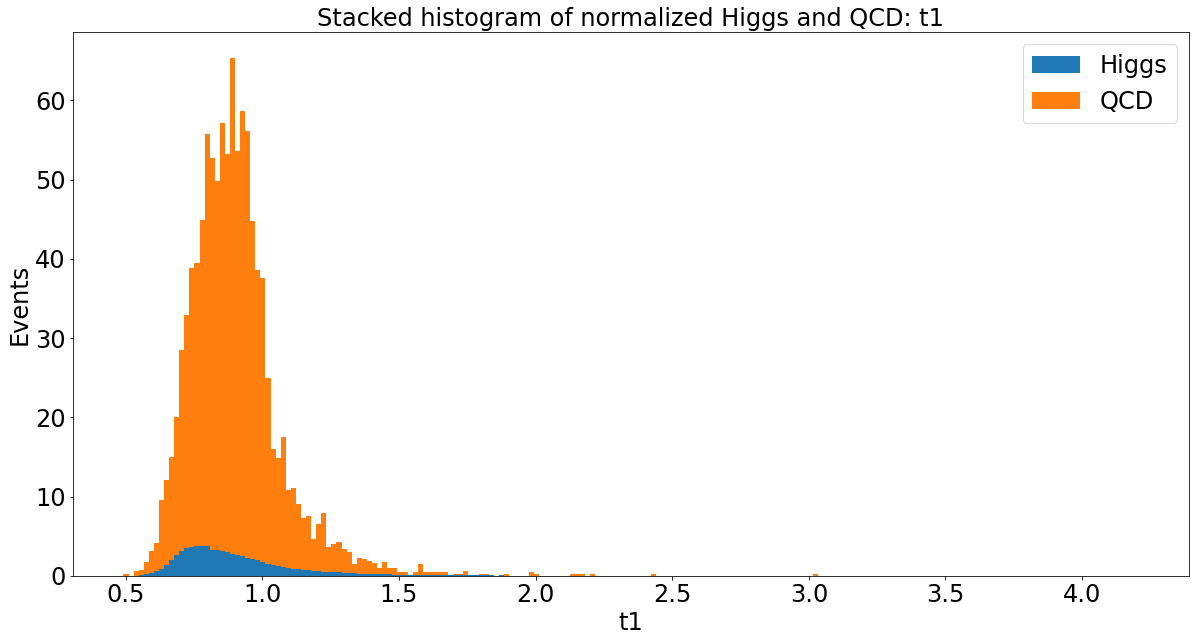

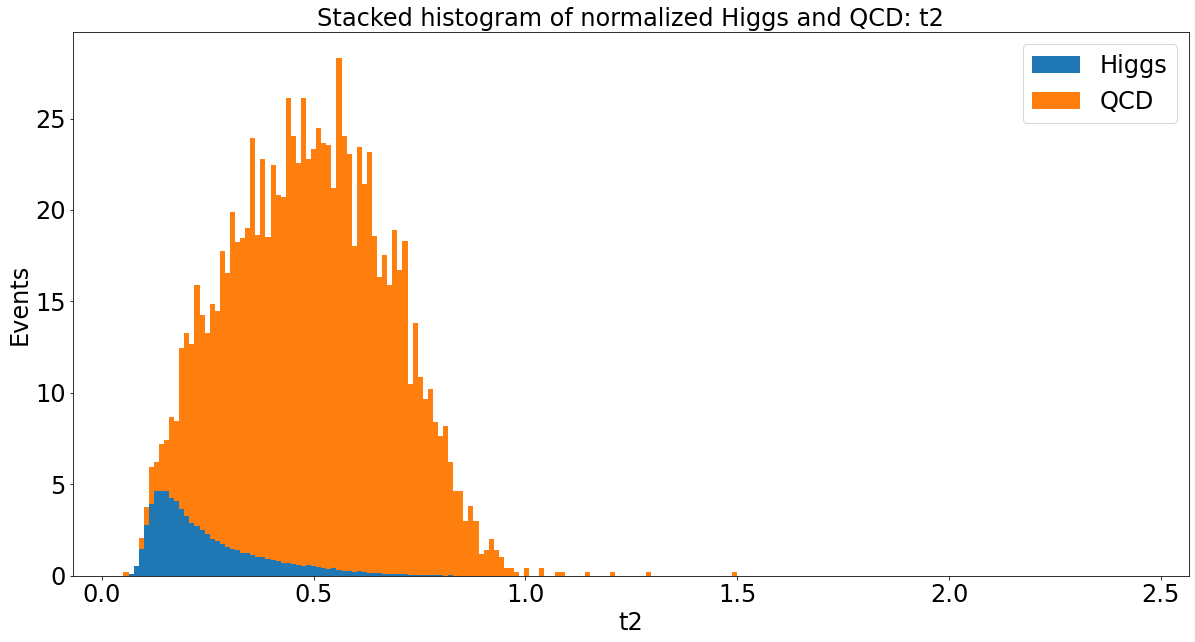

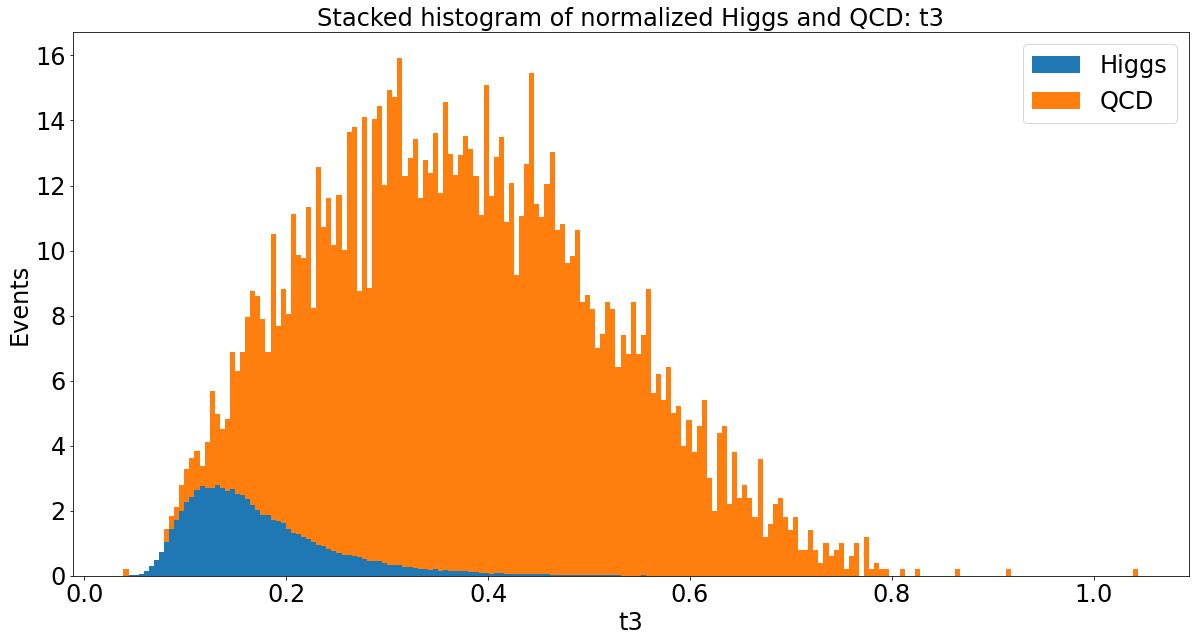

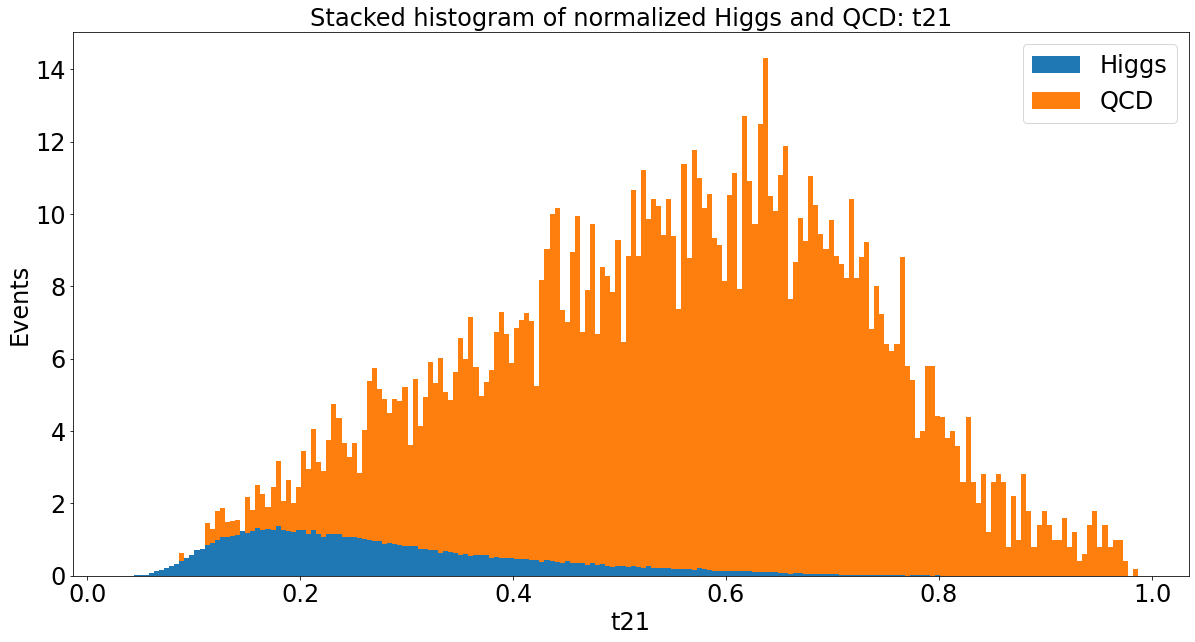

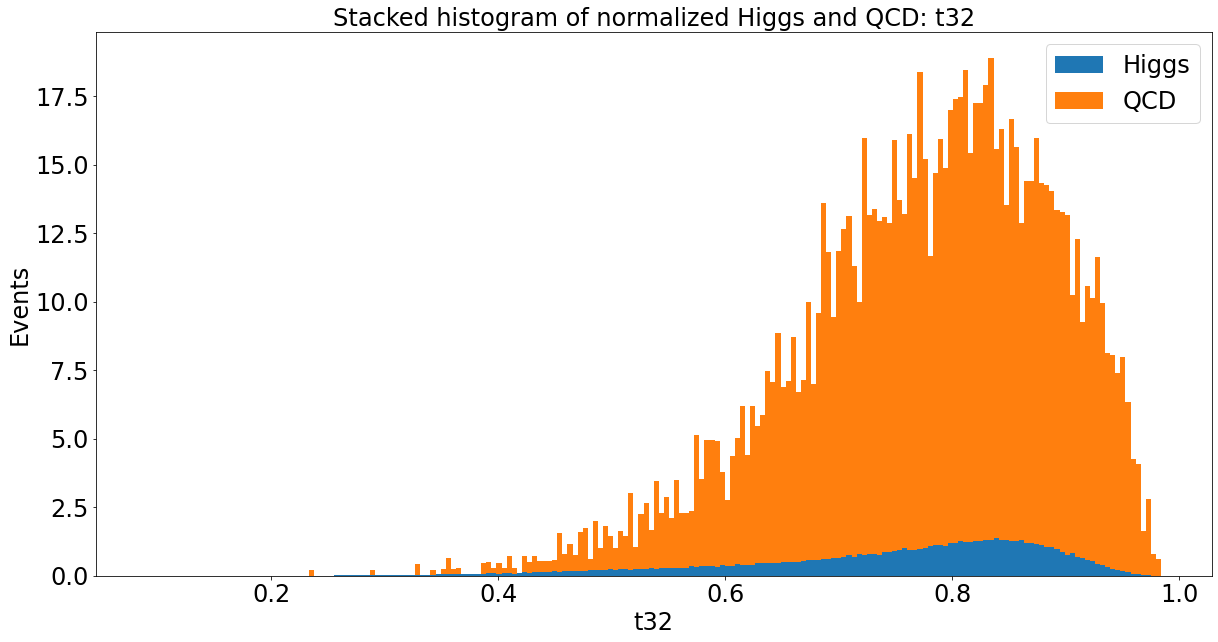

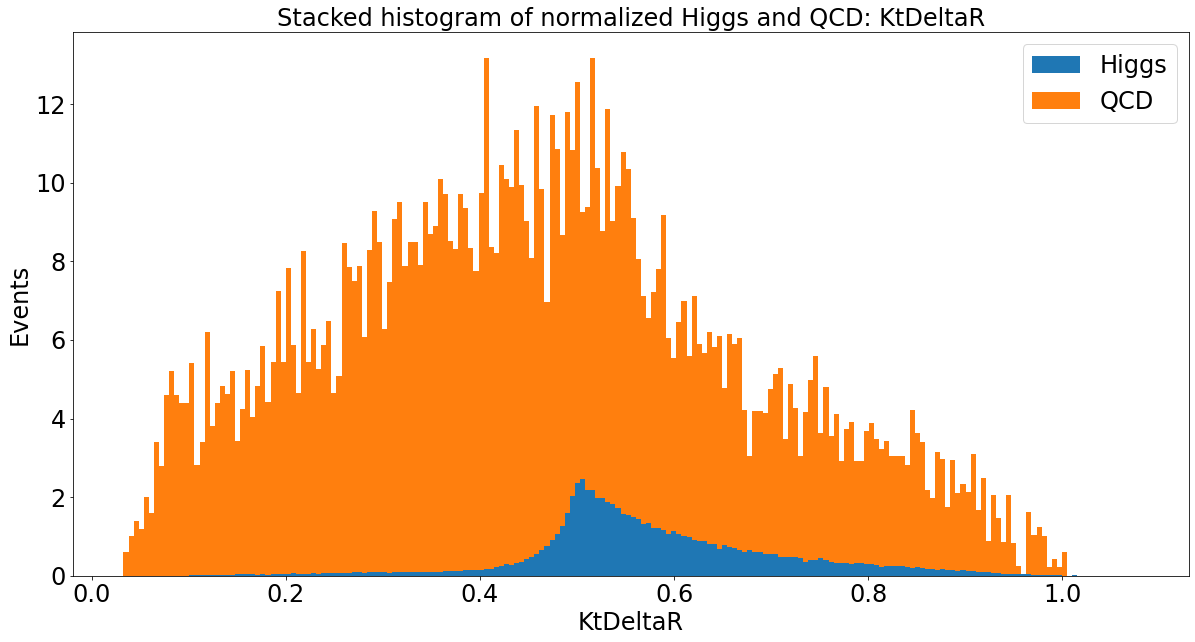

In [101]:
higgs_mass_cut = higgs_data[higgs_data['mass'] > 120]
higgs_mass_cut = higgs_mass_cut[higgs_mass_cut['mass'] < 130]

qcd_massCut = qcd_data[qcd_data['mass'] > 120]
qcd_massCut = qcd_massCut[qcd_massCut['mass'] < 130 ]

for i in cols:
    hists(i, higgs_mass_cut, qcd_massCut)

A number of these features look like they would be reasonably good at further increasing the significance. Of special note are the d2 and t3 variables. For these two variables, the distribution of the qcd is offset from the distribution of higgs events.  


higgs yield = 65
qcd yield = 146
The expected significance is 5.1
higgs yield = 67
qcd yield = 194
The expected significance is 4.5


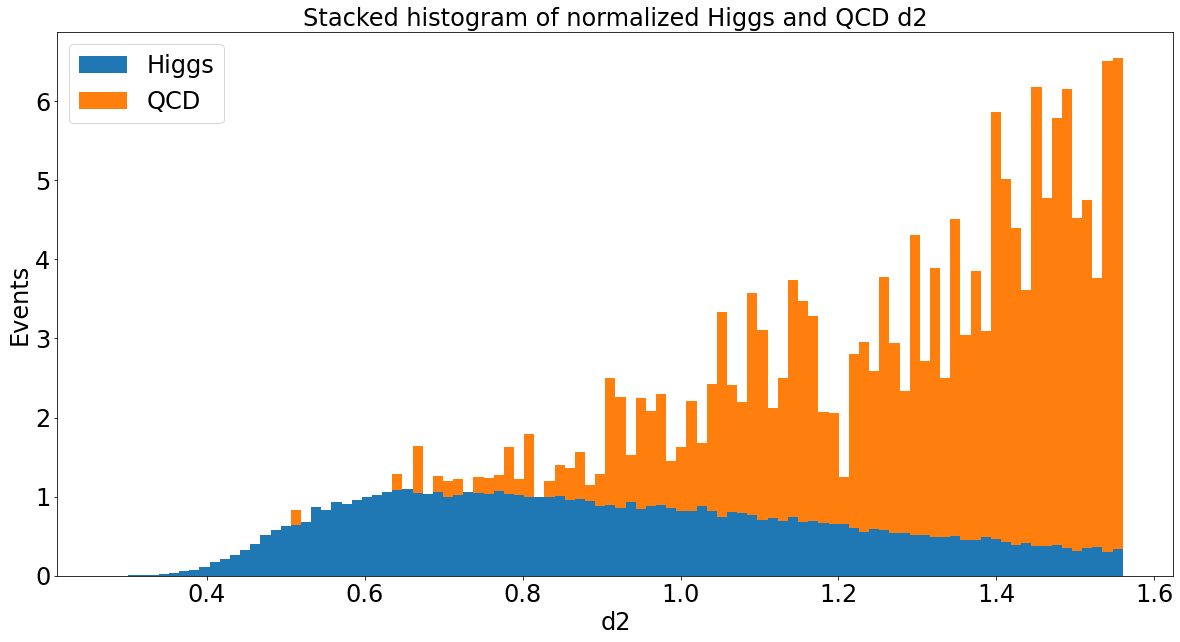

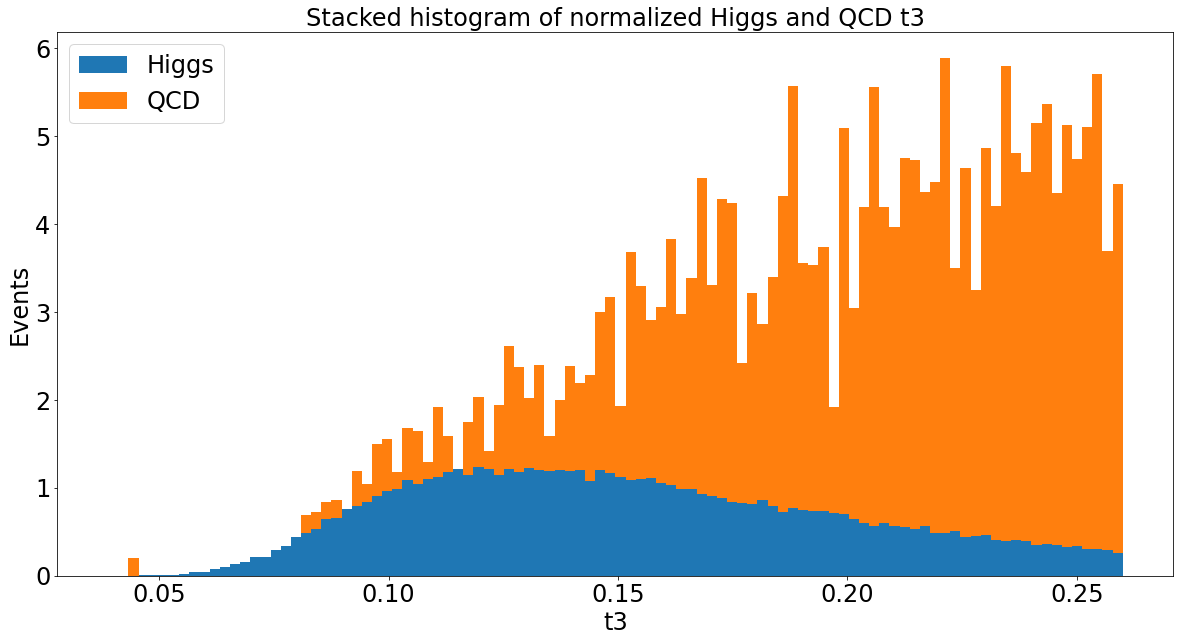

In [110]:
makeStats(0, 1.56, 'd2', higgs_mass_cut, qcd_massCut)
makeStats(0, 0.26, 't3', higgs_mass_cut, qcd_massCut)

The above feature cuts of d2 and t3 demonstrate that d2 is the desired feature cut: the significance is a factor of 10 larger than the uncut data and nearly 2/3 of the higgs events were preserved. For Lab 8, I will proceed with the feature cuts of mass and d2. 

### **4**  
The above feature cuts provide enough event selection to increase the significance with no event selection, 0.71 sigma, to 5 sigma while filtering out nearly 99% of the background. 

# **Lab 8**

# **1. High luminosity**  
 
* *For each feature of the event selection, plot the observed data overlapped with teh signal background with and without event selection*
* *Evaluate the observed significance and compare the results to expectation*


In [20]:
import h5py
import pandas as pd

In [21]:
hf = h5py.File('data_highLumi_pt_250_500.h5', 'r') #Import the file
data = hf['data']

values = data['block0_values'][:]
observed = pd.DataFrame(data = values, columns = cols) # Using the columns from before
hf.close()
observed.columns

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

It is useful to define a function that creates the desired plots. In addition is provides the yeilds of the simulated and observed data after successive cuts as well as the observed significance.

In [111]:
def lab8(feature, observed, higgs, qcd):
    fig, ax = plt.subplots(1,1, figsize = (20, 10))
    plt.tick_params(labelsize = 24)

    higgs_weights = np.repeat(higgs_expected/100000, 
                              len(higgs[feature]))
    qcd_weights = np.repeat((qcd_expected/100000), 
                            len(qcd[feature])) 
    observed_weights = np.repeat(1, 
                                 len(observed[feature]))

    observed_heights, _, _ = ax.hist(observed[feature],
                                    bins = 100,
                                    histtype = 'step',
                                    linewidth = 2,
                                    weights = observed_weights,
                                    label = 'Observed')

    simulated_cut = np.append(higgs[feature].values, qcd[feature].values)
    simulated_weights = np.append(higgs_weights, qcd_weights)

    heights, _, _ = ax.hist(simulated_cut,
                            bins = 100, 
                            histtype = 'step',
                            linewidth = 2,
                            weights = simulated_weights, 
                            label = ['Simulated Data'])

    ax.legend(fontsize = 24)
    ax.set_title(f"Histogram of observed {feature} with overpplotted "
                 f"normalized Higgs and QCD {feature}", fontsize = 24)
    ax.set_xlabel(f"{feature}", fontsize = 24)
    ax.set_ylabel("Events", fontsize = 24)
    
    observed_events = sum(observed_heights)
    print(f'The number of observed events is {observed_events}')
    
    expected_background = ((qcd_expected/100000) * len(qcd[feature]))
    total_events = ((qcd_expected/100000) * len(qcd[feature])) + ((higgs_expected/100000) * len(higgs[feature])) 
    print(f'The number of simulated events is {total_events:0.0f}')
    
    prob = stats.poisson.sf(observed_events, mu = expected_background)
    sig = stats.norm.isf(prob, loc = 0, scale = 1)

    print(f'The observed significance is {sig:0.02f} sigma')

The number of observed events is 40344.0
The number of simulated events is 40344
The observed significance is 1.00 sigma


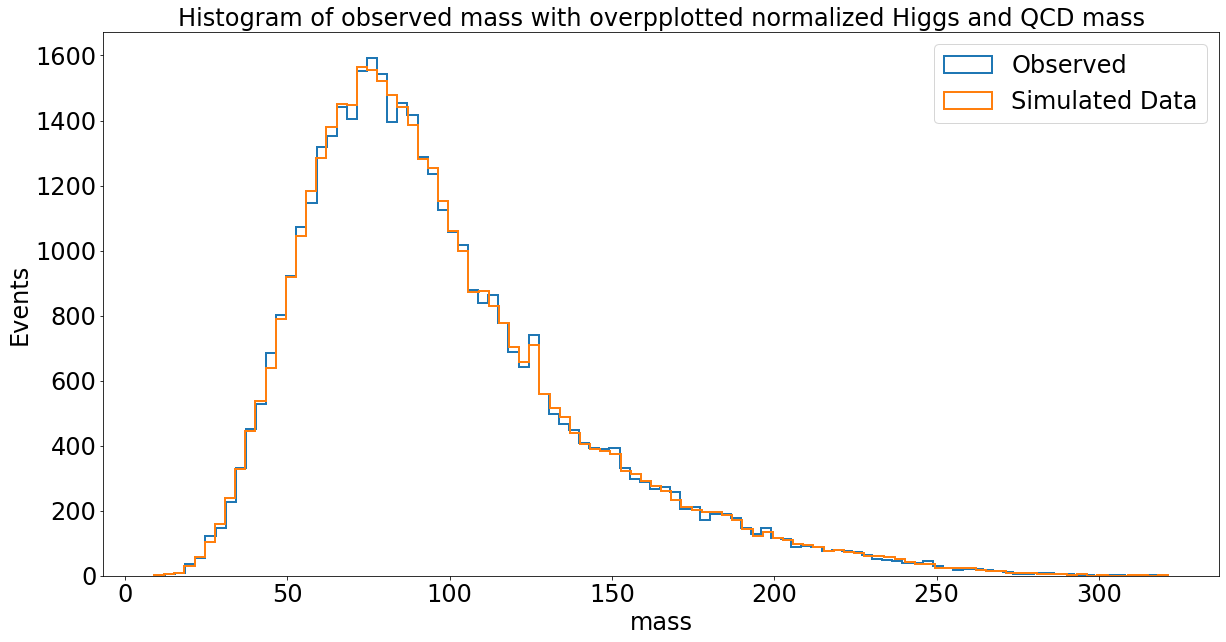

In [112]:
# Calculate the expected number of higgs and QCD events keeping the ratio 100/20000
factor = 40344/20100
higgs_expected = 100 * factor
qcd_expected = 20000 * factor

lab8('mass', observed, higgs_data, qcd_data)

The plot above shows the observed data overplotted with the higgs and qcd sample data normalized to give the exepected yields. The plot below gives the same plot using a mass cut from before. 

The number of observed events is 2135.0
The number of simulated events is 2120
The observed significance is 3.74 sigma


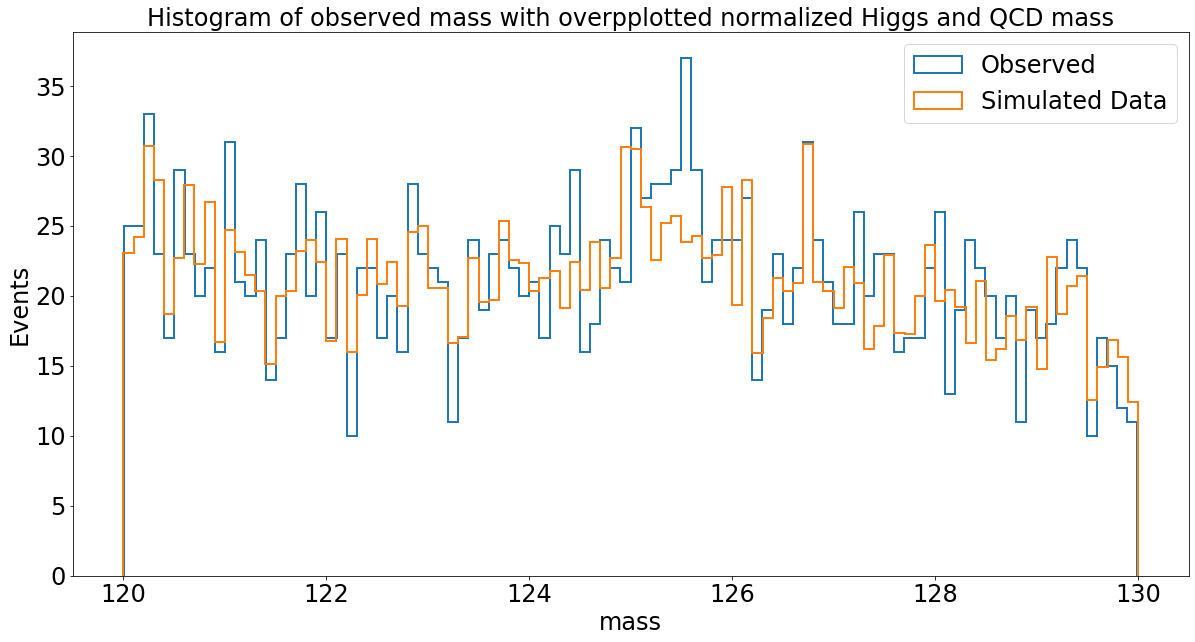

In [113]:
# Cut the observed data

temp1 = observed[observed['mass'] > 120]
observed_mass_cut = temp1[temp1['mass'] < 130]

lab8('mass', observed_mass_cut, higgs_mass_cut, qcd_massCut)

The above plot shows the observed data and the simulated data using the first feature cut: mass. The bolow plot shows the data using the next feature cut: d2.

The number of observed events is 345.0
The number of simulated events is 372
The observed significance is 6.01 sigma


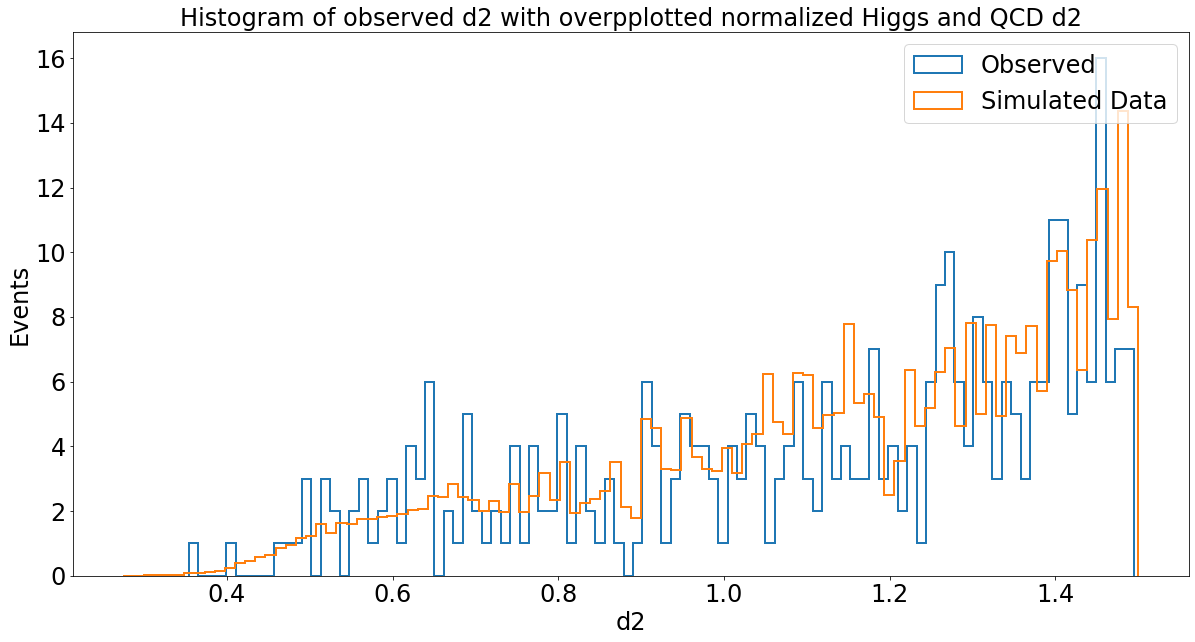

In [114]:
# d2 feature cut: 

observed_d2_cut = observed_mass_cut[observed_mass_cut['d2'] < 1.5]
higgs_d2_cut = higgs_mass_cut[higgs_mass_cut['d2'] < 1.5]
qcd_d2_cut = qcd_massCut[qcd_massCut['d2'] < 1.5]

lab8('d2', observed_d2_cut, higgs_d2_cut, qcd_d2_cut)

The above plot shows the the d2 feature cut after a mass cut for the observed data, and the higgs and qcd simulation data. The final step is to calculate the observed significance. The observed significance can be calculated by checking the leftover number of events and assuming that that number is all background. 

The observed significance using only two cuts, while attempting to keep ~2/3 of the higgs events, is 6 sigma. The expected significance using the same feature cuts gave a significance of 5.1 sigma. This is likely a result of the higher number of events than in the training dataset. 

# **2. Low Luminosity**

In [115]:
hf = h5py.File('data_lowLumi_pt_250_500.h5', 'r') #Import the file
data = hf['data']

values = data['block0_values'][:]
observed_lowl = pd.DataFrame(data = values, columns = cols) # Using the columns from before
hf.close()
print(observed.columns)
observed.shape

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


(40344, 14)

Since the number of events in the low luminosity data is different from the high luminosity data, the simulated data needs to be normalized again. 

In [116]:
factor = 4060/20100 # The number to multiply the expected yeilds by 

higgs_expected = 100 * factor
qcd_expected = 20000 * factor

The number of observed events is 4060.0
The number of simulated events is 4060
The observed significance is 0.33 sigma


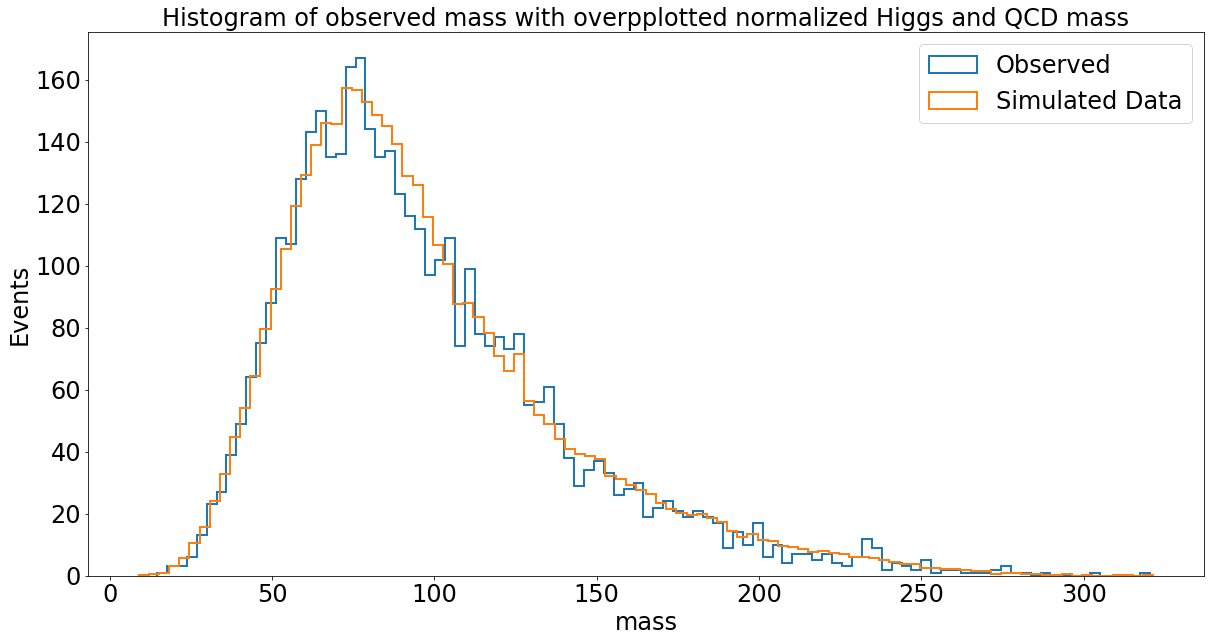

In [117]:
lab8('mass', observed_lowl, higgs_data, qcd_data)

Cut the observed data

The number of observed events is 242.0
The number of simulated events is 213
The observed significance is 3.07 sigma


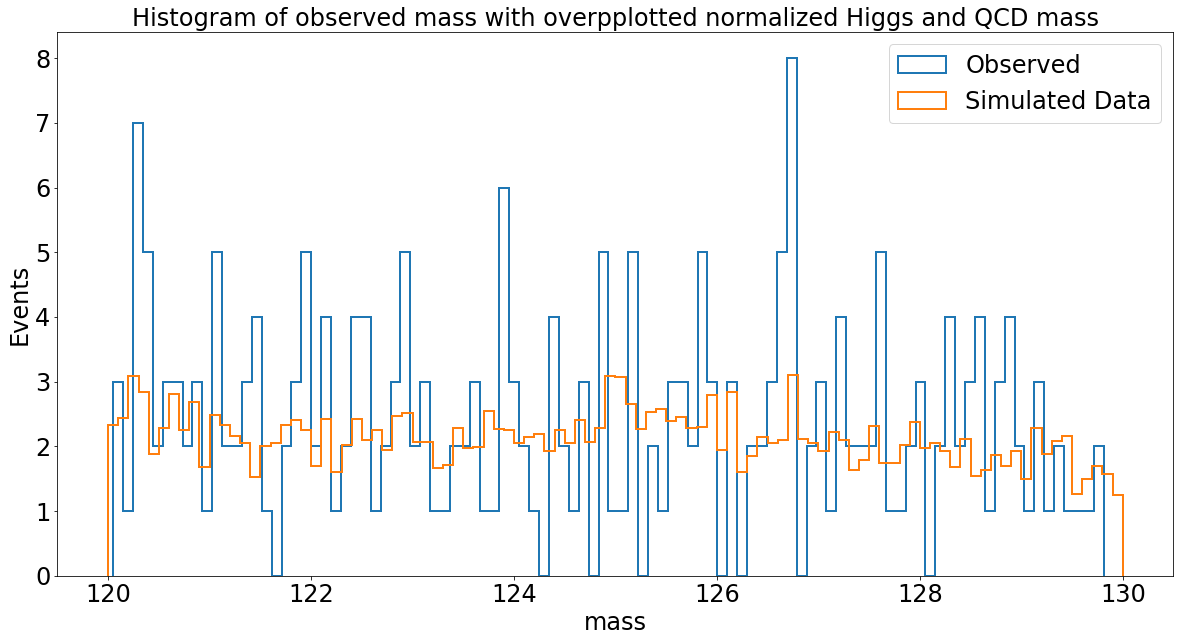

In [118]:
temp = observed_lowl[observed_lowl['mass'] < 130]
observed_mass_cut_lowl = temp[temp['mass'] > 120]

lab8('mass', observed_mass_cut_lowl, higgs_mass_cut, qcd_massCut)

This looks good, now I will cut along the d2 feature.

The number of observed events is 36.0
The number of simulated events is 37
The observed significance is 2.24 sigma


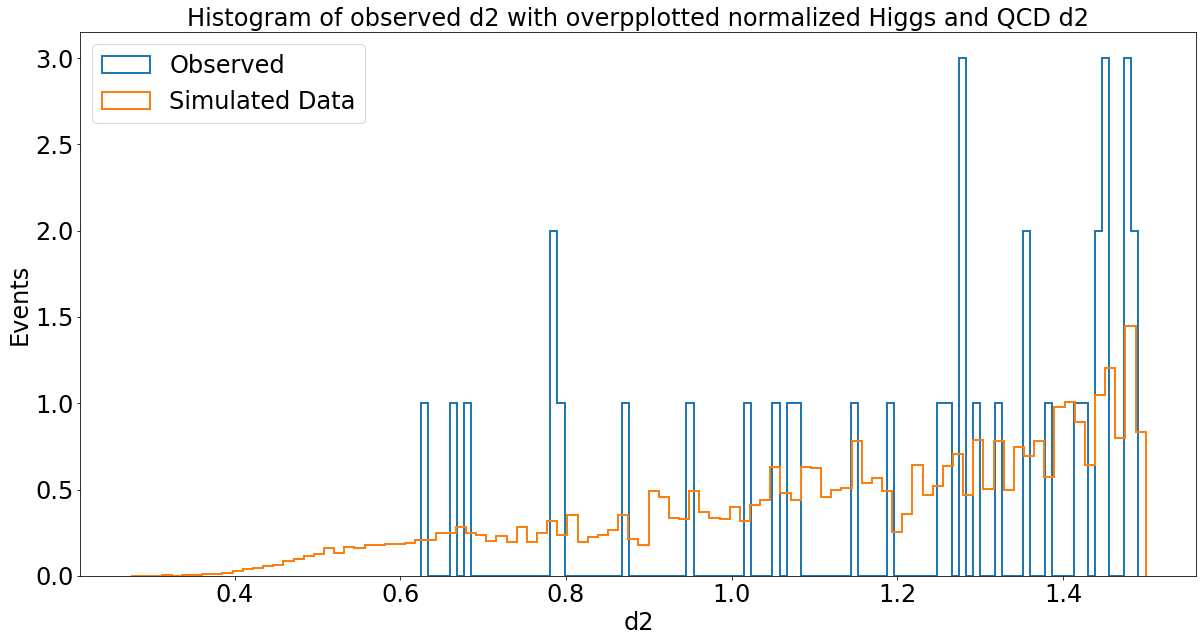

In [119]:
observed_d2_cut = observed_mass_cut_lowl[observed_mass_cut_lowl['d2'] < 1.5]

lab8('d2', observed_d2_cut, higgs_d2_cut, qcd_d2_cut)

The low luminosity data, after the feature cuts, only contains 36 events. This is drastically less than the 345 included in the high luminosity dataset. Correspondingly the significance associated is 2.24 sigma. 

## **95% Confidence Level of Signal Yield**

* *Evaluate the expected 95% confidence level upper limit*

The calculation of the confidence interval assumes that each feature cut keeps the same fraction of higgs and qcd events as from lab 7. In this way, given the number of events that lie with the feature cut for a given data set, simulated or low luminosity, it is possible to calculate the distribution of signals that gave the observation, and then find the 95th percentile of that distribution.

In [122]:
#fractions kept by feature cuts
qcd_frac = qcd_d2_cut.shape[0] / 100000 
higgs_frac = higgs_d2_cut.shape[0] / 100000

# Total events kept by feature cuts
cut_simulated_events = qcd_d2_cut.shape[0] * qcd_weight + higgs_d2_cut.shape[0] * higgs_weight


injected_signal = np.linspace(0, 200, 10000000)
higgs_events = stats.poisson.rvs(mu = injected_signal)
higgs_saved = higgs_frac * higgs_events
qcd_saved = qcd_frac * (20100 - higgs_events)
cut_signal = higgs_saved + qcd_saved
signal_distribution = injected_signal[np.abs(cut_signal - cut_simulated_events) < 1]
expected_upper_limit = np.percentile(signal_distribution, 95)
expected_percent_yield = expected_upper_limit / 20100
print(f'The expected 95% confidence upper limit for the higgs yeild is {expected_upper_limit:0.0f} or'
      f' {expected_percent_yield:0.05f}')


The expected 95% confidence upper limit for the higgs yeild is 118 or 0.00588


In [123]:
#fractions kept by feature cuts
qcd_frac = qcd_d2_cut.shape[0] / 100000 
higgs_frac = higgs_d2_cut.shape[0] / 100000

# Total events kept by feature cuts
cut_simulated_events = qcd_d2_cut.shape[0] * qcd_weight + higgs_d2_cut.shape[0] * higgs_weight


injected_signal = np.linspace(0, 50, 10000000)
higgs_events = stats.poisson.rvs(mu = injected_signal)
higgs_saved = higgs_frac * higgs_events
qcd_saved = qcd_frac * (4060 - higgs_events) # Number of low lumi events
cut_signal = higgs_saved + qcd_saved
signal_distribution = injected_signal[np.abs(cut_signal - observed_d2_cut.shape[0]) < 1]
expected_upper_limit = np.percentile(signal_distribution, 95)
expected_percent_yield = expected_upper_limit / 4060
print(f'The observed 95% confidence upper limit for the higgs yeild is {expected_upper_limit:0.0f} or'
      f' {expected_percent_yield:0.05f}')


The observed 95% confidence upper limit for the higgs yeild is 27 or 0.00661


The observed 95% confidence level upper limit for the observed data is 27 events or 0.661%. This is greater than the expected 95% confidence upper limit which corresponded to a percent yeild of 0.588%. This is a result of the smaller sample of events: this leads to greater uncertainty and as a result the confidence level takes a greater value. 